# E-commerce Recommendation System

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Business Understanding

### Project Overview
E-commerce platforms rely on personalized recommendations to improve user experience, increase engagement, and drive sales. Customers interact with products through various events such as **views, clicks, and add-to-cart actions**, but these interactions are often unstructured. The goal of this project is to **build a recommendation system that predicts item properties for "add to cart" events based on prior "view" events** while also detecting abnormal user behavior to enhance recommendation accuracy.

### Business Objectives
1. **Improve Personalization**
   - Predict which product properties influence a user's decision to add an item to the cart.
   - Help businesses tailor their recommendations based on implicit browsing behavior.

2. **Reduce Noise and Improve Efficiency**
   - Identify and remove **abnormal users** who introduce bias and noise into the dataset.
   - Ensure data quality for better recommendation performance.

3. **Enhance Customer Engagement and Sales**
   - Deliver relevant product recommendations, increasing conversion rates.
   - Improve user retention by optimizing the browsing experience.

### Problem Statement
- Customers interact with multiple products before making a purchase decision. However, the properties influencing these decisions (e.g., price, brand, availability) are not explicitly logged.
- **How can we infer product properties that contribute to an "add to cart" decision based on past "view" events?**
- Additionally, **how can we detect and filter out abnormal users who distort recommendation accuracy?**

### Data Understanding
The project relies on three key datasets:

#### 1. `events.csv` (User Interaction Data)
| Column       | Description |
|-------------|------------|
| `timestamp`  | Time when the interaction occurred. |
| `visitorid`  | Unique identifier for each user. |
| `event`      | Type of interaction (e.g., view, add to cart). |
| `itemid`     | Unique identifier for each product. |
| `transactionid` | Identifies transactions (for purchases). |

#### 2. `item_properties.csv` (Product Metadata)
| Column       | Description |
|-------------|------------|
| `timestamp`  | Time when the property was recorded. |
| `itemid`     | Product identifier. |
| `property`   | Feature of the product (e.g., category, availability). |
| `value`      | Corresponding value of the property. |

#### 3. `category_tree.csv` (Product Category Data)
| Column       | Description |
|-------------|------------|
| `categoryid`  | Child category identifier |
| `parentid`     | Parent category identifier. |

### Project Scope
- **Task 1:** Develop an algorithm to predict item properties for "add to cart" events based on "view" events.
- **Task 2:** Detect abnormal users who generate noise and remove them to improve recommendation accuracy.

By addressing these tasks, the project will deliver a robust recommendation system that enhances **e-commerce personalization** and **business intelligence insights** while ensuring **clean and reliable data**. 🚀

### Hypothesis Testing
- **Null Hypothesis(Ho):**
- **Alternate Hypothesis(Ha):**

### Analytical Questions
1. Do the most viewed items also have the highest add-to-cart and transaction counts?
2. Does a visitor number of views for a certain item influences his/decision to add the item to cart?
3. What are the most transacted item?
4. How can we detect and filter out abnormal users who distort recommendation accuracy?
5. What are the most add to cart item?
6. Which particular time of the day has the most transactions?
7. What is the view to "add to cart" conversion rate?
8. What is the "addtocart" to "transactions" conversion rate?


In [2]:
!pip install implicit

#### Import all necessary libraries

In [3]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Statistical Libraries
from scipy import stats
from scipy.stats import ttest_ind
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

# Feature Engineering Libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


# Machine Learning Libraries
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
import xgboost as xgb
from implicit.als import AlternatingLeastSquares

# Metrics Libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Utils
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

print("Successfully imported all libraries...")

Successfully imported all libraries...


#### Data Understanding

In [4]:
# Load datasets
events_df = pd.read_csv('/content/drive/MyDrive/data/events.csv')
item_properties1_df = pd.read_csv('/content/drive/MyDrive/data/item_properties_part1.1.csv')
item_properties2_df = pd.read_csv('/content/drive/MyDrive/data/item_properties_part2.csv', dtype={"property":"object"})
category_tree_df = pd.read_csv('/content/drive/MyDrive/data/category_tree.csv')



In [5]:
# Load the events_df
events_df

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [6]:
# Load the category_tree_df
category_tree_df

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [7]:
# Load the item_properties1_df
item_properties1_df

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [8]:
# Load the item_properties2_df
item_properties2_df

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062
...,...,...,...,...
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062


#### Concatenate the item properties dataframes

In [9]:
item_properties_df = pd.concat([item_properties1_df,item_properties2_df],ignore_index=True)

# Display the first few rows of the concatenated dataframe
item_properties_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [10]:
# check the shape of the new items_properties_df
item_properties_df.shape

(20275902, 4)

#### Create New Features from Property column of the item_properties

In [11]:
# initialize the categoryid and available columns
item_properties_df["categoryid"] = np.nan
item_properties_df["available"] = np.nan

# Assign values to the new column based on the 'property' column
item_properties_df.loc[item_properties_df["property"] == "categoryid","categoryid"] = item_properties_df["value"]
item_properties_df.loc[item_properties_df["property"] == "available","available"] = item_properties_df["value"]

In [12]:
# Move all the already existing numerical category ids into categoryid column
item_properties_df.loc[item_properties_df["property"].str.isnumeric(), "categoryid"] = item_properties_df["property"]

In [13]:
# create new column called description column
item_properties_df["description"] = item_properties_df.apply(
    lambda row: row["value"] if row["property"] not in ["categoryid","available"] else np.nan, axis=1 )


In [14]:
# drop unnecessary property and value columns
item_properties_df.drop(["property", "value"], axis=1, inplace=True)

In [15]:
# confirm changes
item_properties_df

,timestamp,itemid,categoryid,available,description
0,1435460400000,460429,1338,NaN,NaN
1,1441508400000,206783,888,NaN,1116713 960601 n277.200
2,1439089200000,395014,400,NaN,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,NaN,n15360.000
4,1431831600000,156781,917,NaN,828513
...,...,...,...,...,...
20275897,1433646000000,236931,929,NaN,n12.000
20275898,1440903600000,455746,6,NaN,150169 639134
20275899,1439694000000,347565,686,NaN,610834
20275900,1433646000000,287231,867,NaN,769062


In [16]:
# Get info about the item_properties_df
item_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   timestamp    int64 
 1   itemid       int64 
 2   categoryid   object
 3   available    object
 4   description  object
dtypes: int64(2), object(3)
memory usage: 773.5+ MB


In [17]:
# check for null values
item_properties_df.isna().sum()

,0
timestamp,0
itemid,0
categoryid,1503639
available,18772263
description,2291853


In [18]:
# Look at the events_df
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [19]:
# check for null values
events_df.isna().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733644


In [20]:
item_properties_df.duplicated().sum()

np.int64(0)

#### Merging Datasets
-  I will first convert the timestamp to datetime so I will base merge on it
- The next step is to merge the item_properties and the category_tree datasets using a left join.
- I shall finally merge the events and item_properties-category-tree mered datasets.
- The merge strategy to be used for merging the events_df and the item_properties-category_tree datasets using merge-asof.
- I shall consider the datetime and the itemid as the two unique columns to base my joins on.


In [21]:
# Convert timestamp in item properties to datetime
item_properties_df["timestamp"] = pd.to_datetime(item_properties_df["timestamp"], unit="ms")

# Convert timestamp in events to
events_df["timestamp"] = pd.to_datetime(events_df["timestamp"], unit="ms")

item_properties_df["timestamp"] = item_properties_df["timestamp"].dt.floor("s")
events_df["timestamp"] = events_df["timestamp"].dt.floor("s")


In [22]:
# confirm changes
item_properties_df["timestamp"].head()

,timestamp
0,2015-06-28 03:00:00
1,2015-09-06 03:00:00
2,2015-08-09 03:00:00
3,2015-05-10 03:00:00
4,2015-05-17 03:00:00


In [23]:
item_properties_df["timestamp"].tail()

,timestamp
20275897,2015-06-07 03:00:00
20275898,2015-08-30 03:00:00
20275899,2015-08-16 03:00:00
20275900,2015-06-07 03:00:00
20275901,2015-09-13 03:00:00


In [24]:
# Rename timestamp columns to datetime column
item_properties_df = item_properties_df.rename(columns = {"timestamp":"datetime"})
events_df = events_df.rename(columns={"timestamp": "datetime"})

In [25]:
# Convert datetime dtype to s
item_properties_df["datetime"] = item_properties_df["datetime"].astype("datetime64[s]")
events_df["datetime"] = events_df["datetime"].astype("datetime64[s]")


In [26]:
# Convert the categoryid and available to int datatype
item_properties_df["categoryid"] = item_properties_df["categoryid"].astype("Int64")
item_properties_df["available"] = item_properties_df["available"].astype("Int64")


In [27]:
# merge items and category_tree dataframe
item_cat_df = item_properties_df.merge(category_tree_df, how="left", on="categoryid")

In [28]:
# preview first five rows of item_cat_df
item_cat_df.head()

,datetime,itemid,categoryid,available,description,parentid
0,2015-06-28 03:00:00,460429,1338,<NA>,NaN,1278.0
1,2015-09-06 03:00:00,206783,888,<NA>,1116713 960601 n277.200,866.0
2,2015-08-09 03:00:00,395014,400,<NA>,n552.000 639502 n720.000 424566,110.0
3,2015-05-10 03:00:00,59481,790,<NA>,n15360.000,1492.0
4,2015-05-17 03:00:00,156781,917,<NA>,828513,1374.0


In [29]:
# check for shape of data
item_cat_df.shape

(20275902, 6)

In [30]:
# check for duplicates
item_cat_df.duplicated().sum()

np.int64(0)

In [31]:
# check for percentage of null values
item_cat_df.isna().sum()/item_cat_df.shape[0]*100

,0
datetime,0.000000
itemid,0.000000
categoryid,7.415892
available,92.584108
description,11.303334
parentid,8.242923


##### Handling Null Values In Item-Cat Merged Dataframe
- I will be filling the missing values in these columns using contextual filling.
- The item-id,categoryid, and the parent-id columns forms a hierarchical tree, meaning the categoryid depends on parent-id and the item-id depends on the parent-id.
- The categoryid will then be filled with the mode categoryid of each item id and same applies to the filling of parentid using the categoryid.
- The description column too will be contextually filled using the categoryid.

In [32]:
# Create a dictionary for the most frequent categoryid for every item-id
item_category_dict = item_cat_df.groupby("itemid")["categoryid"].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
item_category_dict


{0: 6,
 1: 790,
 2: 112,
 3: 283,
 4: 888,
 5: 6,
 6: 790,
 7: 6,
 8: 6,
 10: 6,
 11: 6,
 12: 6,
 13: 6,
 14: 6,
 15: 776,
 16: 790,
 17: 6,
 18: 776,
 19: 790,
 20: 790,
 21: 19,
 22: 790,
 23: 6,
 24: 790,
 25: 790,
 26: 790,
 27: 790,
 28: 888,
 29: 400,
 30: 6,
 31: 6,
 32: 888,
 33: 6,
 34: 283,
 35: 6,
 36: 6,
 38: 6,
 39: 6,
 40: 790,
 41: 6,
 42: 790,
 43: 6,
 44: 6,
 45: 6,
 48: 888,
 49: 6,
 50: 6,
 51: 888,
 52: 6,
 53: 6,
 54: 6,
 55: 6,
 56: 6,
 57: 6,
 58: 6,
 59: 6,
 60: 6,
 62: 888,
 64: 6,
 65: 6,
 66: 776,
 67: 6,
 68: 888,
 69: 6,
 70: 6,
 71: 6,
 72: 888,
 73: 6,
 74: 678,
 75: 790,
 76: 776,
 77: 6,
 78: 888,
 79: 790,
 80: 112,
 81: 888,
 82: 6,
 83: 6,
 84: 6,
 85: 888,
 86: 6,
 87: 6,
 88: 828,
 89: 6,
 90: 6,
 91: 6,
 92: 790,
 93: 19,
 94: 888,
 95: 1036,
 96: 6,
 97: 6,
 98: 6,
 99: 6,
 100: 790,
 101: 790,
 102: 790,
 103: 6,
 104: 6,
 105: 6,
 106: 6,
 107: 888,
 108: 6,
 109: 888,
 110: 6,
 112: 790,
 113: 888,
 114: 888,
 115: 888,
 116: 888,
 117: 1,
 11

In [33]:
# Fill Null Values in the Categoryid using the item_cat_dict
item_cat_df["categoryid"].fillna(item_cat_df["itemid"].map(item_category_dict), inplace=True)

In [34]:
# Create a dictionary for the most frequent parentid from categoryid
cat_parent_dict = item_cat_df.groupby("categoryid")["parentid"].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
cat_parent_dict


{np.int64(0): 605.0,
 np.int64(1): 854.0,
 np.int64(2): 312.0,
 np.int64(3): 1281.0,
 np.int64(4): 1266.0,
 np.int64(5): 1637.0,
 np.int64(6): 933.0,
 np.int64(7): 250.0,
 np.int64(8): 1591.0,
 np.int64(9): 351.0,
 np.int64(10): 994.0,
 np.int64(11): 1439.0,
 np.int64(12): 1110.0,
 np.int64(13): 1495.0,
 np.int64(14): 1684.0,
 np.int64(15): 1327.0,
 np.int64(16): 585.0,
 np.int64(17): 1604.0,
 np.int64(18): 170.0,
 np.int64(19): 750.0,
 np.int64(20): 1299.0,
 np.int64(21): 351.0,
 np.int64(22): 1550.0,
 np.int64(23): 640.0,
 np.int64(24): 1292.0,
 np.int64(25): 1490.0,
 np.int64(26): 1546.0,
 np.int64(27): 557.0,
 np.int64(28): 1604.0,
 np.int64(29): 1678.0,
 np.int64(30): 1009.0,
 np.int64(31): 336.0,
 np.int64(32): 1687.0,
 np.int64(33): 1224.0,
 np.int64(34): 1368.0,
 np.int64(35): 20.0,
 np.int64(36): 893.0,
 np.int64(37): 945.0,
 np.int64(38): 418.0,
 np.int64(39): 540.0,
 np.int64(40): 1632.0,
 np.int64(41): 1658.0,
 np.int64(42): 170.0,
 np.int64(43): 945.0,
 np.int64(44): 110.0

In [35]:
# Fill Null Values in the parentid using the cat_dict
item_cat_df["parentid"].fillna(item_cat_df["categoryid"].map(cat_parent_dict), inplace=True)

In [36]:
# Create a dictionary for the most frequent description from categoryid
cat_description_dict = item_cat_df.groupby("categoryid")["description"].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
cat_description_dict


{np.int64(0): '769062',
 np.int64(1): '1200832',
 np.int64(2): '769062',
 np.int64(3): '769062',
 np.int64(4): 'n72.000 807959',
 np.int64(5): '1116693',
 np.int64(6): '1115994',
 np.int64(7): '605947',
 np.int64(8): '769062',
 np.int64(9): '554317',
 np.int64(10): '1116693',
 np.int64(11): 'n23040.000 628176 n12960.000',
 np.int64(12): '191208',
 np.int64(13): 'n121.200',
 np.int64(14): 'n72.000 628176',
 np.int64(15): '111364',
 np.int64(16): '523129 683595',
 np.int64(17): 'n115.200 324082',
 np.int64(18): 'n20.400 190776',
 np.int64(19): '1297729 n36.000 350726 30603 832471',
 np.int64(20): '1116693',
 np.int64(21): '1225881',
 np.int64(22): '769062',
 np.int64(23): '769062',
 np.int64(24): '769062',
 np.int64(25): '1211562',
 np.int64(26): '769062',
 np.int64(27): '36842',
 np.int64(28): '150169 610517',
 np.int64(29): '769062',
 np.int64(30): '769062',
 np.int64(31): '779362 177264 n24108.000',
 np.int64(32): 'n48.000',
 np.int64(33): '1128577 1000087 421694',
 np.int64(34): '892

In [37]:
# Fill Null Values in the parentid using the cat_dict
item_cat_df["description"].fillna(item_cat_df["categoryid"].map(cat_description_dict), inplace=True)

In [38]:
# Calculate percentage of null values after filling them
item_cat_df.isna().sum()/item_cat_df.shape[0]*100

,0
datetime,0.000000
itemid,0.000000
categoryid,0.000000
available,92.584108
description,1.697192
parentid,0.832836


Considering the few percentage of Null Values within the decription and parentid columns, I will drop all the rows with these null values since it won't have much impact on my analysis.

In [39]:
# Drop all the rows with null values in the description and parentid columns
item_cat_df.dropna(subset=["description", "parentid"], inplace=True)

In [40]:
# Final shape of item_cat_df
item_cat_df.shape

(19762933, 6)

###### Merge Item-Cat and Events Using Merge-asof

In [41]:
# Sort item_cat_df by timestamp and itemid
item_cat_df = item_cat_df.sort_values(by=["datetime", "itemid"])

# Sort events_df by timestamp and itemid
events_df = events_df.sort_values(by=["datetime", "itemid"])

In [42]:
# Merge using nearest timestamp and match within each itemid
final_df = pd.merge_asof(
    events_df,
    item_cat_df,
    on="datetime",
    by="itemid",
    direction="nearest",
    tolerance=pd.Timedelta(days=1))


#### Exploratory Data Analysis

In [43]:
# check the shape of the final_df
final_df.shape

(2756101, 9)

In [44]:
# View first five rows
final_df.head()

,datetime,visitorid,event,itemid,transactionid,categoryid,available,description,parentid
0,2015-05-03 03:00:04,693516,addtocart,297662,NaN,<NA>,<NA>,NaN,NaN
1,2015-05-03 03:00:11,829044,view,60987,NaN,<NA>,<NA>,NaN,NaN
2,2015-05-03 03:00:13,652699,view,252860,NaN,<NA>,<NA>,NaN,NaN
3,2015-05-03 03:00:24,1125936,view,33661,NaN,<NA>,<NA>,NaN,NaN
4,2015-05-03 03:00:26,693516,view,297662,NaN,<NA>,<NA>,NaN,NaN


In [45]:
# check the info about final_df
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 9 columns):
 #   Column         Dtype        
---  ------         -----        
 0   datetime       datetime64[s]
 1   visitorid      int64        
 2   event          object       
 3   itemid         int64        
 4   transactionid  float64      
 5   categoryid     Int64        
 6   available      Int64        
 7   description    object       
 8   parentid       float64      
dtypes: Int64(2), datetime64[s](1), float64(2), int64(2), object(2)
memory usage: 194.5+ MB


In [46]:
# perform summary descriptive analysis on the final_df
final_df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,2756101,2015-07-09 06:48:07,2015-05-03 03:00:04,2015-06-05 04:23:14,2015-07-09 14:43:33,2015-08-10 16:45:05,2015-09-18 02:59:47,NaN
visitorid,2756101.0,701922.883229,0.0,350566.0,702060.0,1053437.0,1407579.0,405687.520809
itemid,2756101.0,234922.478375,3.0,118120.0,236067.0,350715.0,466867.0,134195.425214
transactionid,22457.0,8826.497796,0.0,4411.0,8813.0,13224.0,17671.0,5098.99629
categoryid,497953.0,688.483781,0.0,591.0,790.0,888.0,1104.0,263.866482
available,75425.0,0.832045,0.0,1.0,1.0,1.0,1.0,0.373829
parentid,497953.0,1067.47333,8.0,866.0,1009.0,1492.0,1698.0,460.339471


In [47]:
# check for duplicates
final_df.duplicated().sum()

np.int64(4092)

In [48]:
# drop duplicates
final_df.drop_duplicates(inplace=True)

In [49]:
# confirm changes
final_df.duplicated().sum()

np.int64(0)

In [50]:
# shape of final_df after dropping duplicates
final_df.shape

(2752009, 9)

In [51]:
# check for null values
final_df.isna().sum()

,0
datetime,0
visitorid,0
event,0
itemid,0
transactionid,2729558
categoryid,2254788
available,2676693
description,2254788
parentid,2254788


In [52]:
# calculate percentage of null values
(final_df.isna().sum()/final_df.shape[0])*100

,0
datetime,0.000000
visitorid,0.000000
event,0.000000
itemid,0.000000
transactionid,99.184196
categoryid,81.932436
available,97.263236
description,81.932436
parentid,81.932436


#### Summary of Missing Values
- transactionid (99.18% missing) → Mostly missing, likely because many events are not purchases.
- available (97.26 % missing) →All data values are missing after merging the three datasets.
- categoryid (81.93 missing) → A huge percentage is missing, likely due to unmapped items.
- description (81.93% missing) → Product descriptions may be optional or unavailable.
- parentid (81.93% missing) → Could be due to items not having a parent category.

#### Strategies for handling missing values
- I will use contextual filling to fill null values in the categoryid,parentid and description columns
- The available and the transactionid columns will be dropped due its huge number of missing values.



##### Filling Null Values in the Final_df

In [53]:
# use contextual filling on the item-id cateoryid column
item_category_dict = final_df.groupby("itemid")["categoryid"].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
item_category_dict

{3: None,
 4: None,
 6: 686,
 9: None,
 15: 790,
 16: 790,
 17: None,
 19: 790,
 22: None,
 24: 790,
 25: 888,
 26: 790,
 29: 400,
 32: 400,
 33: 97,
 37: None,
 40: 71,
 41: None,
 42: 790,
 46: None,
 47: None,
 49: None,
 54: None,
 55: None,
 56: 997,
 58: None,
 59: None,
 60: None,
 61: None,
 63: None,
 65: None,
 66: 405,
 68: None,
 71: None,
 73: None,
 75: None,
 77: None,
 78: None,
 80: None,
 87: 202,
 88: 993,
 90: None,
 91: 6,
 92: None,
 93: None,
 95: None,
 98: 917,
 102: 917,
 105: None,
 106: None,
 108: None,
 111: None,
 112: None,
 117: None,
 118: 888,
 119: None,
 123: None,
 124: None,
 125: None,
 128: None,
 130: None,
 133: 19,
 134: 888,
 135: 888,
 136: None,
 137: None,
 138: None,
 139: None,
 142: 1090,
 143: None,
 144: None,
 147: 915,
 151: None,
 152: None,
 153: None,
 154: None,
 155: None,
 160: 888,
 162: None,
 163: 790,
 165: None,
 168: 822,
 169: None,
 170: 900,
 173: None,
 174: 451,
 175: None,
 181: None,
 185: None,
 189: None,
 190:

In [54]:
# Fill Null Values in the categoryid column using the item_cat_dict
final_df["categoryid"].fillna(final_df["itemid"].map(item_category_dict), inplace=True)

In [55]:
# crete categoryid parentid column using the mode parentid
cat_parent_dict = final_df.groupby("categoryid")["parentid"].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
cat_parent_dict

{np.int64(0): 605.0,
 np.int64(1): 854.0,
 np.int64(2): 312.0,
 np.int64(3): 1281.0,
 np.int64(5): 1637.0,
 np.int64(6): 933.0,
 np.int64(7): 250.0,
 np.int64(8): 1591.0,
 np.int64(9): 351.0,
 np.int64(10): 994.0,
 np.int64(11): 1439.0,
 np.int64(12): 1110.0,
 np.int64(13): 1495.0,
 np.int64(14): 1684.0,
 np.int64(15): 1327.0,
 np.int64(16): 585.0,
 np.int64(18): 170.0,
 np.int64(19): 750.0,
 np.int64(22): 1550.0,
 np.int64(23): 640.0,
 np.int64(25): 1490.0,
 np.int64(26): 1546.0,
 np.int64(27): 557.0,
 np.int64(28): 1604.0,
 np.int64(29): 1678.0,
 np.int64(30): 1009.0,
 np.int64(32): 1687.0,
 np.int64(33): 1224.0,
 np.int64(34): 1368.0,
 np.int64(35): 20.0,
 np.int64(36): 893.0,
 np.int64(37): 945.0,
 np.int64(38): 418.0,
 np.int64(39): 540.0,
 np.int64(40): 1632.0,
 np.int64(41): 1658.0,
 np.int64(42): 170.0,
 np.int64(43): 945.0,
 np.int64(44): 110.0,
 np.int64(45): 903.0,
 np.int64(46): 1519.0,
 np.int64(47): 381.0,
 np.int64(48): 500.0,
 np.int64(49): 1125.0,
 np.int64(50): 312.0,

In [56]:
# Fill Null Values in the parentid column using the cat_parent_dict
final_df["parentid"].fillna(final_df["categoryid"].map(cat_parent_dict), inplace=True)

In [57]:
# Create a dictionary map for the categoryid, description columns
cat_description_dict = final_df.groupby("categoryid")["description"].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
cat_description_dict

{np.int64(0): '934278 388767 1235560',
 np.int64(1): '1200832',
 np.int64(2): '769062',
 np.int64(3): '1116693',
 np.int64(5): '1116693',
 np.int64(6): '1115994',
 np.int64(7): '144396',
 np.int64(8): '769062',
 np.int64(9): '554317',
 np.int64(10): '1116693',
 np.int64(11): 'n23040.000 628176 n12960.000',
 np.int64(12): '472016 181384',
 np.int64(13): 'n84.000',
 np.int64(14): 'n144.000 628176',
 np.int64(15): '111364',
 np.int64(16): '523129 683595',
 np.int64(18): 'n20.400 190776',
 np.int64(19): '1297729 n36.000 350726 30603 832471',
 np.int64(22): '769062',
 np.int64(23): '769062',
 np.int64(25): '466400 1226584 1211562',
 np.int64(26): '769062',
 np.int64(27): '36842',
 np.int64(28): '150169 610517',
 np.int64(29): '769062',
 np.int64(30): '769062',
 np.int64(32): 'n24.000',
 np.int64(33): '1128577 1000087 421694',
 np.int64(34): '892975',
 np.int64(35): '539109 661116 1257525',
 np.int64(36): '91437',
 np.int64(37): 'n60.000',
 np.int64(38): '769062',
 np.int64(39): '1116693',
 

In [58]:
# Fill missing values in the description columns using the cat_description_dict
final_df["description"].fillna(final_df["categoryid"].map(cat_description_dict), inplace=True)

In [59]:
# drop the transactionid column
columns_to_drop = ["transactionid","available"]
final_df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [60]:
# calculate the percentage of null values after dropping columns
(final_df.isna().sum()/final_df.shape[0])*100

,0
datetime,0.000000
visitorid,0.000000
event,0.000000
itemid,0.000000
categoryid,19.598773
description,19.598773
parentid,19.598773


In [61]:
# Look out for the rows with Null values
rows_with_nulls = final_df[final_df.isna().any(axis=1)]
rows_with_nulls


,datetime,visitorid,event,itemid,categoryid,description,parentid
2,2015-05-03 03:00:13,652699,view,252860,<NA>,NaN,NaN
15,2015-05-03 03:00:49,1233000,view,396707,<NA>,NaN,NaN
16,2015-05-03 03:00:51,1222029,view,75831,<NA>,NaN,NaN
17,2015-05-03 03:00:54,990356,view,161722,<NA>,NaN,NaN
18,2015-05-03 03:01:00,142337,view,155847,<NA>,NaN,NaN
...,...,...,...,...,...,...,...
2756087,2015-09-18 02:58:12,896271,view,376315,<NA>,NaN,NaN
2756090,2015-09-18 02:58:54,90973,view,300166,<NA>,NaN,NaN
2756091,2015-09-18 02:58:57,485144,view,14990,<NA>,NaN,NaN
2756096,2015-09-18 02:59:24,472345,view,301436,<NA>,NaN,NaN


Looking at the Rows with Null Values, we can observe that they are the all from the null values in the columns of categoryid,parentid and description.
With this insight, I am going to drop all these rows of about 19.60% of my entire data.
- There is still about 80% of the dataset that can be used for my analysis and modelling.  

In [62]:
# Drop rows with Null Values
final_df.dropna(inplace=True)

In [63]:
# calculate the percentage of null values after handling the null values in the final_df
(final_df.isna().sum()/final_df.shape[0])*100

,0
datetime,0.0
visitorid,0.0
event,0.0
itemid,0.0
categoryid,0.0
description,0.0
parentid,0.0


In [64]:
# Get the shape of the final_df
final_df.shape

(2212649, 7)

I have 2212649 rows and 7 columns for my analysis

In [65]:
final_df.head()

,datetime,visitorid,event,itemid,categoryid,description,parentid
0,2015-05-03 03:00:04,693516,addtocart,297662,790,n0.000,1492.0
1,2015-05-03 03:00:11,829044,view,60987,186,769062,865.0
3,2015-05-03 03:00:24,1125936,view,33661,790,n0.000,1492.0
4,2015-05-03 03:00:26,693516,view,297662,790,n0.000,1492.0
5,2015-05-03 03:00:27,1149227,view,29757,790,n0.000,1492.0


#### Univariate Analysis

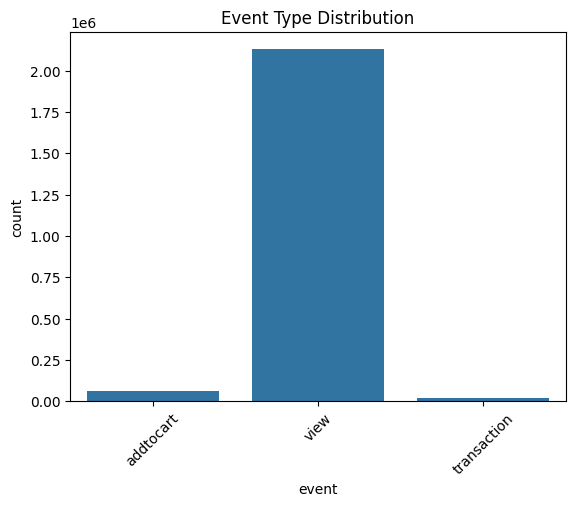

In [66]:
# countplot of event
sns.countplot(x=final_df["event"])
plt.title("Event Type Distribution")
plt.xticks(rotation=45)  # Rotate for readability
plt.show()


There is an uneven distribution of events. A very few events ended up in transaction, a few in add to cart and the majority of the events being the view event.

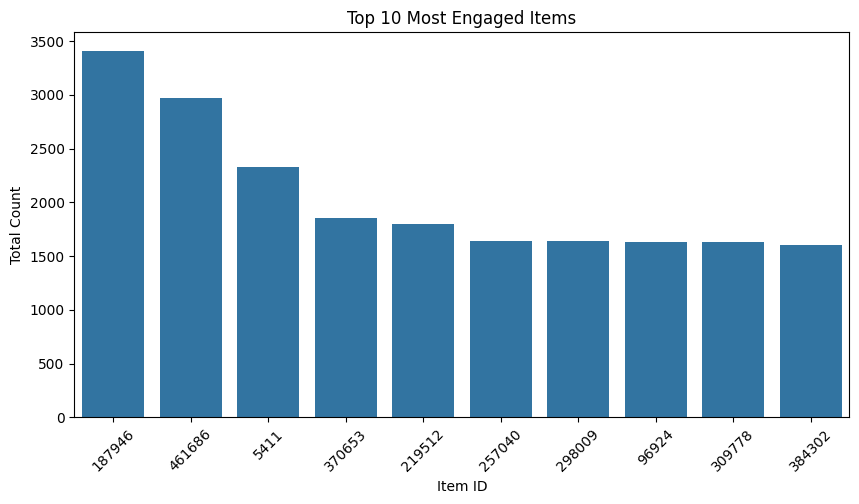

In [67]:
# Get the top 10 most engaged items
top_items = final_df["itemid"].value_counts().nlargest(10)
top_items = top_items.sort_values(ascending=False)  # order ids in descending order

plt.figure(figsize=(10, 5))
sns.barplot(x=top_items.index.astype(str), y=top_items.values)  # Convert IDs to string
plt.title("Top 10 Most Engaged Items")
plt.xlabel("Item ID")
plt.ylabel("Total Count")
plt.xticks(rotation=45)
plt.show()


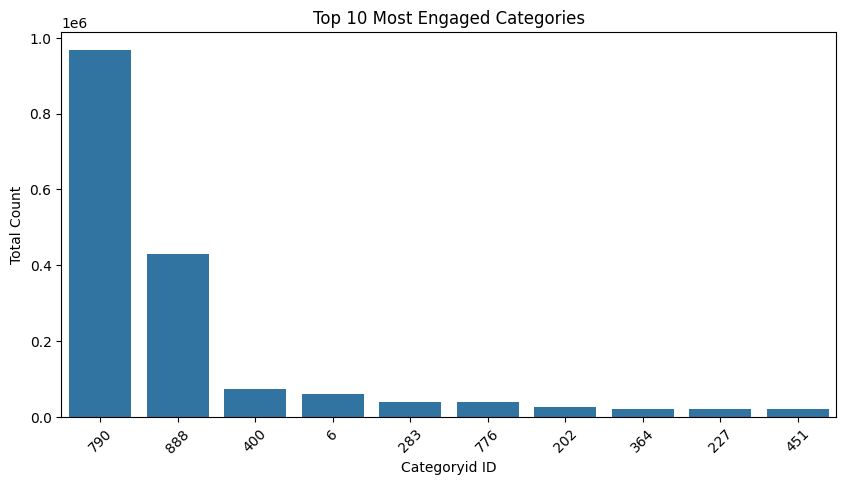

In [68]:
# Get the top 10 most engaged categories
top_items = final_df["categoryid"].value_counts().nlargest(10)
top_items = top_items.sort_values(ascending=False)  # order ids in descending order

plt.figure(figsize=(10, 5))
sns.barplot(x=top_items.index.astype(str), y=top_items.values)  # Convert IDs to string
plt.title("Top 10 Most Engaged Categories")
plt.xlabel("Categoryid ID")
plt.ylabel("Total Count")
plt.xticks(rotation=45)
plt.show()


#### Feature Engineering

In [69]:
# Split datetime
final_df["month"] = final_df["datetime"].dt.month
final_df["day"] = final_df["datetime"].dt.day
final_df["dayname"] = final_df["datetime"].dt.day_name()
final_df["hour"] = final_df["datetime"].dt.hour
final_df["minute"] = final_df["datetime"].dt.minute
final_df["second"] = final_df["datetime"].dt.second



In [70]:
# view first five rows data after splitting datetime
final_df.head()

,datetime,visitorid,event,itemid,categoryid,description,parentid,month,day,dayname,hour,minute,second
0,2015-05-03 03:00:04,693516,addtocart,297662,790,n0.000,1492.0,5,3,Sunday,3,0,4
1,2015-05-03 03:00:11,829044,view,60987,186,769062,865.0,5,3,Sunday,3,0,11
3,2015-05-03 03:00:24,1125936,view,33661,790,n0.000,1492.0,5,3,Sunday,3,0,24
4,2015-05-03 03:00:26,693516,view,297662,790,n0.000,1492.0,5,3,Sunday,3,0,26
5,2015-05-03 03:00:27,1149227,view,29757,790,n0.000,1492.0,5,3,Sunday,3,0,27


In [71]:
# view last five rows data after splitting datetime
final_df.tail()

,datetime,visitorid,event,itemid,categoryid,description,parentid,month,day,dayname,hour,minute,second
2756094,2015-09-18 02:59:12,525390,view,299222,790,n0.000,1492.0,9,18,Friday,2,59,12
2756095,2015-09-18 02:59:13,998517,view,354400,810,769062,378.0,9,18,Friday,2,59,13
2756097,2015-09-18 02:59:25,1207677,view,310922,888,1314085,866.0,9,18,Friday,2,59,25
2756099,2015-09-18 02:59:41,622226,view,345308,790,n0.000,1492.0,9,18,Friday,2,59,41
2756100,2015-09-18 02:59:47,1287495,view,98299,978,17670,747.0,9,18,Friday,2,59,47


#### Time Series Analysis

##### Analysis on Views

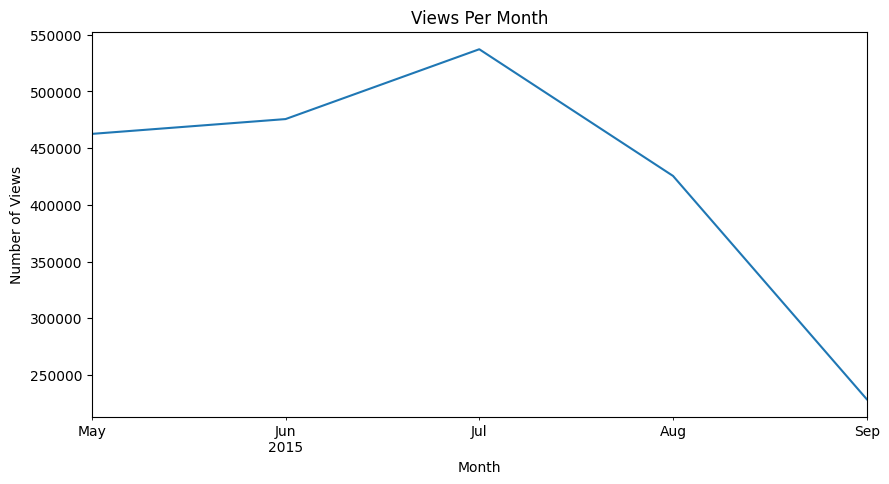

In [72]:
final_df.set_index('datetime', inplace=True) #set datetime as index
# number of views per month
monthly_views = final_df[final_df['event'] == 'view'].resample('M').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Views Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Views')
plt.show()

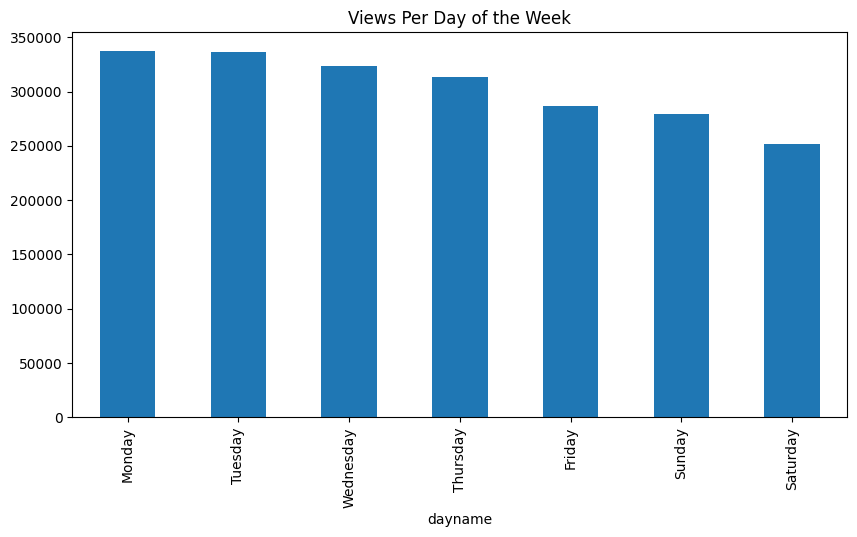

In [73]:
# Number of views per day
views_by_dayname = final_df[final_df['event'] == 'view'].groupby('dayname').size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
views_by_dayname.plot(kind='bar')
plt.title('Views Per Day of the Week')
plt.show()

Can be seen from the analysis that the number of views reduces as we move towards the weekends.

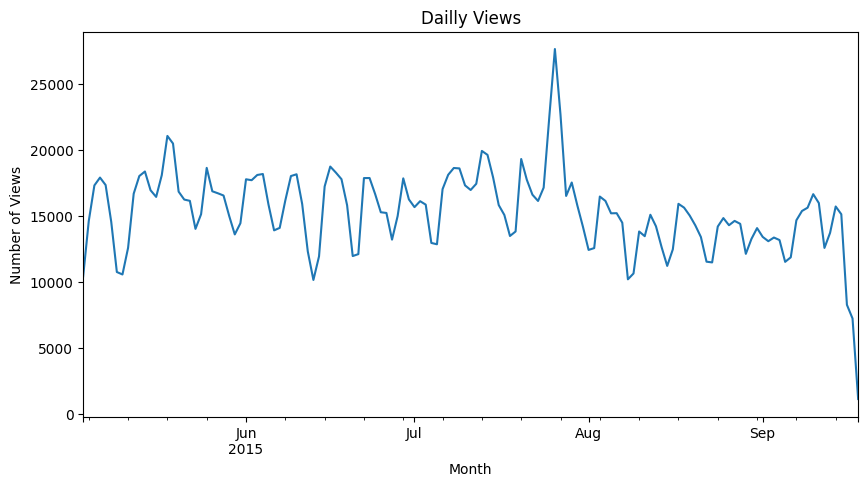

In [74]:
# number of views per day
monthly_views = final_df[final_df['event'] == 'view'].resample('D').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Dailly Views')
plt.xlabel('Month')
plt.ylabel('Number of Views')
plt.show()

##### Add to Cart Analysis

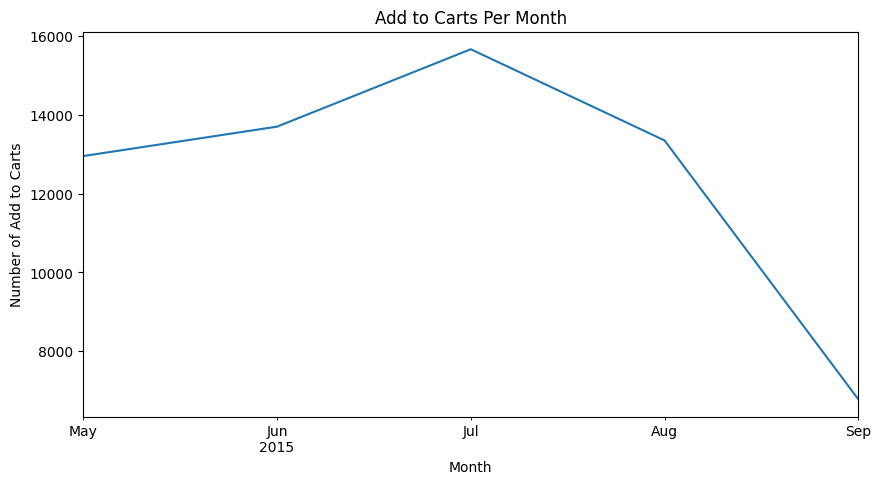

In [75]:
# number of views per month
monthly_views = final_df[final_df['event'] == 'addtocart'].resample('M').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Add to Carts Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Add to Carts')
plt.show()

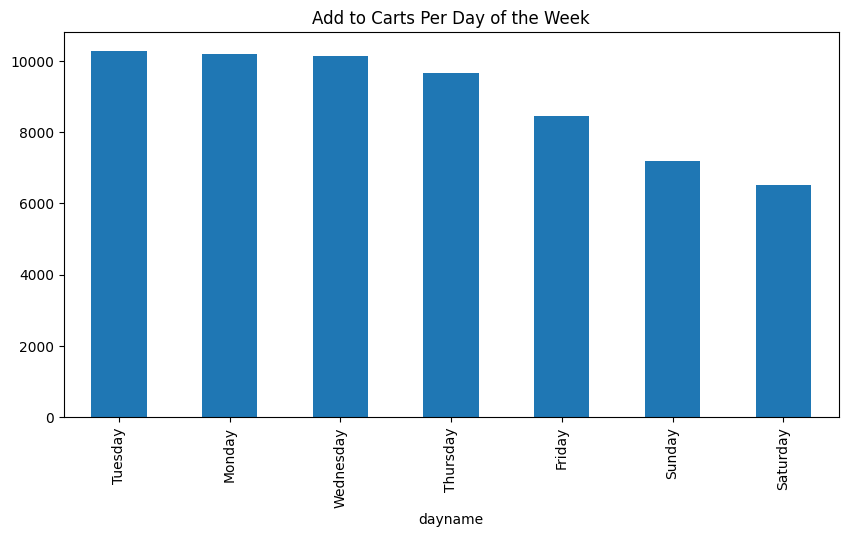

In [76]:
# Number of views per day
views_by_dayname = final_df[final_df['event'] == 'addtocart'].groupby('dayname').size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
views_by_dayname.plot(kind='bar')
plt.title('Add to Carts Per Day of the Week')
plt.show()

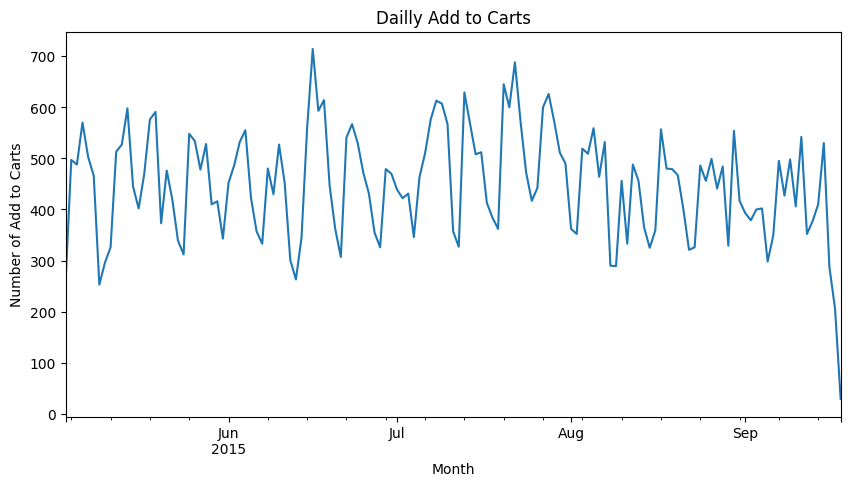

In [77]:
# number of add to carts per day
monthly_views = final_df[final_df['event'] == 'addtocart'].resample('D').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Dailly Add to Carts')
plt.xlabel('Month')
plt.ylabel('Number of Add to Carts')
plt.show()

- It can be observed that the number of products been added to cart normaly peaks from the beginning of the month into the middle of the month and it retards during the ending days of the month.

###### Transaction Analysis

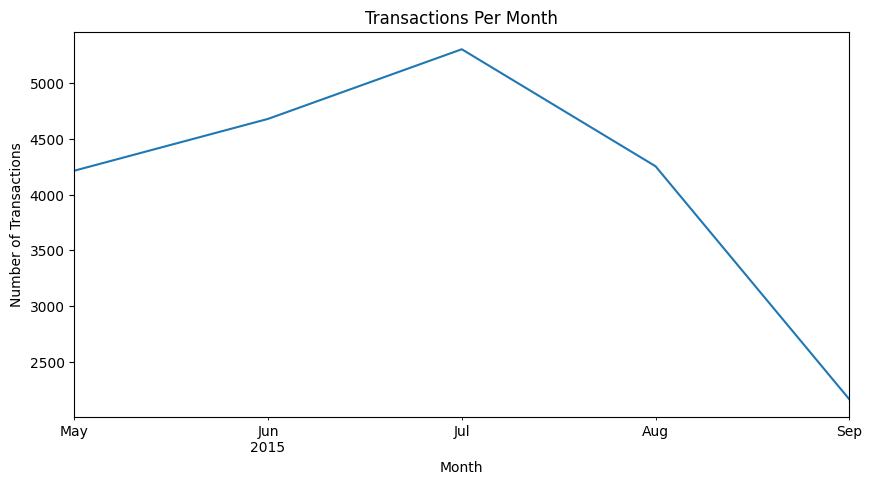

In [78]:
# number of views per month
monthly_views = final_df[final_df['event'] == 'transaction'].resample('M').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Transactions Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

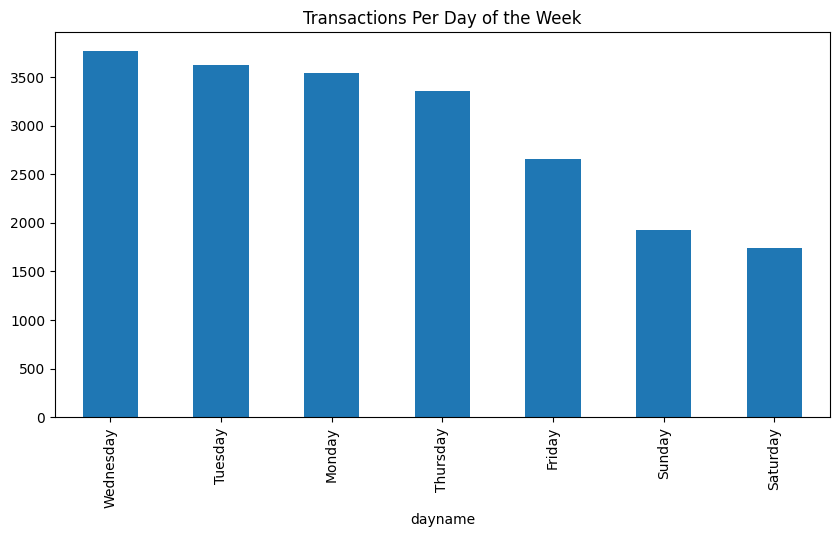

In [79]:
# Number of views per day
views_by_dayname = final_df[final_df['event'] == 'transaction'].groupby('dayname').size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
views_by_dayname.plot(kind='bar')
plt.title('Transactions Per Day of the Week')
plt.show()

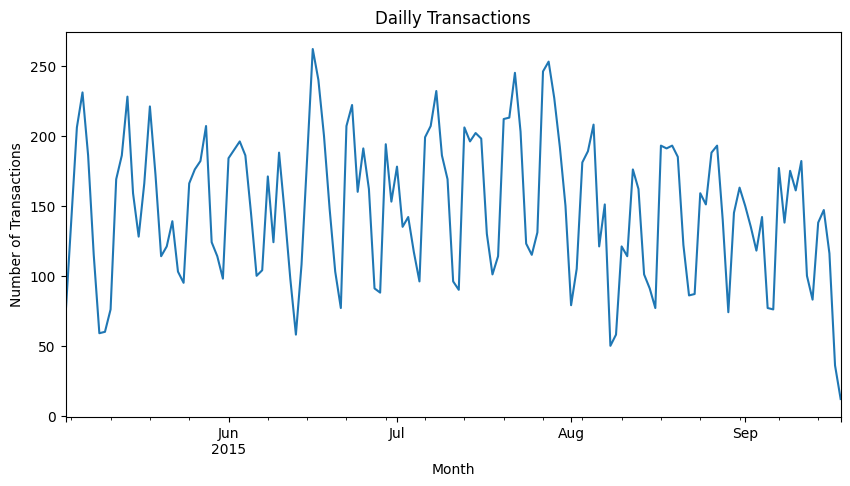

In [80]:
# number of transactions per day
monthly_transactions = final_df[final_df['event'] == 'transaction'].resample('D').size()
plt.figure(figsize=(10, 5))
monthly_transactions.plot(kind='line')
plt.title('Dailly Transactions')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

###### Busiest Hour for Most Transactions

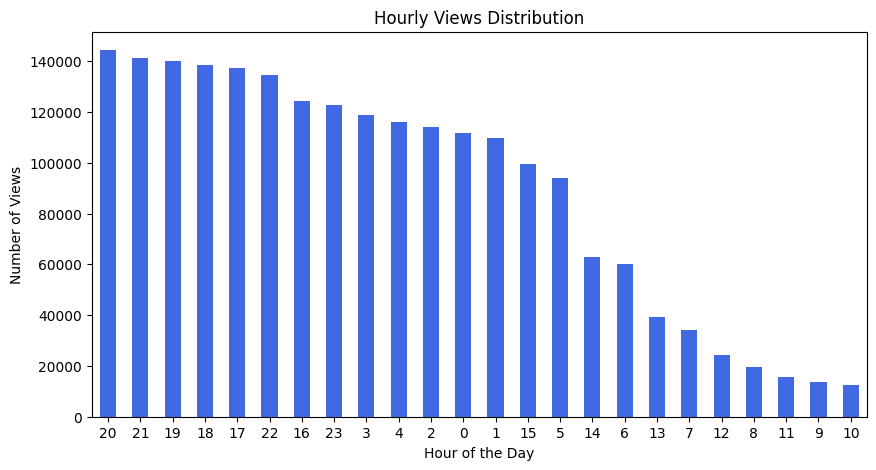

In [81]:
# most bussiest hour of the day
hourly_views = final_df[final_df['event'] == 'view'].groupby("hour").size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
hourly_views.plot(kind='bar', color="royalblue")
plt.title("Hourly Views Distribution")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Views")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.show()


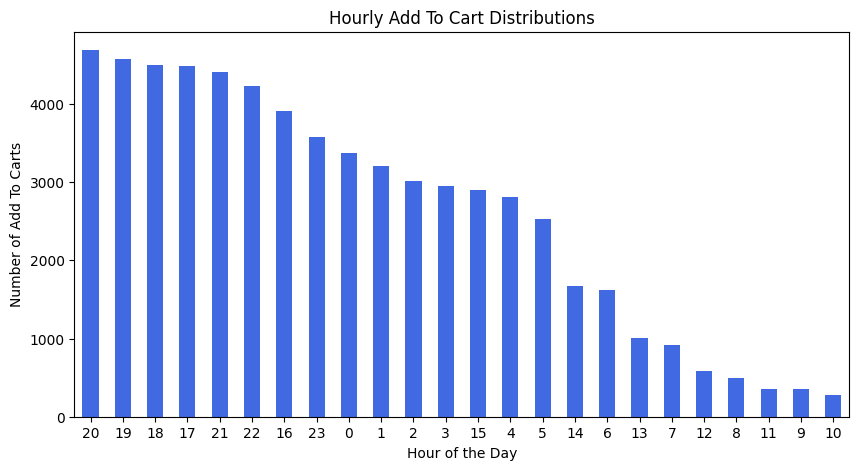

In [82]:
# most bussiest hour of the day
hourly_addtocarts = final_df[final_df['event'] == 'addtocart'].groupby("hour").size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
hourly_addtocarts.plot(kind='bar', color="royalblue")
plt.title("Hourly Add To Cart Distributions")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Add To Carts")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.show()


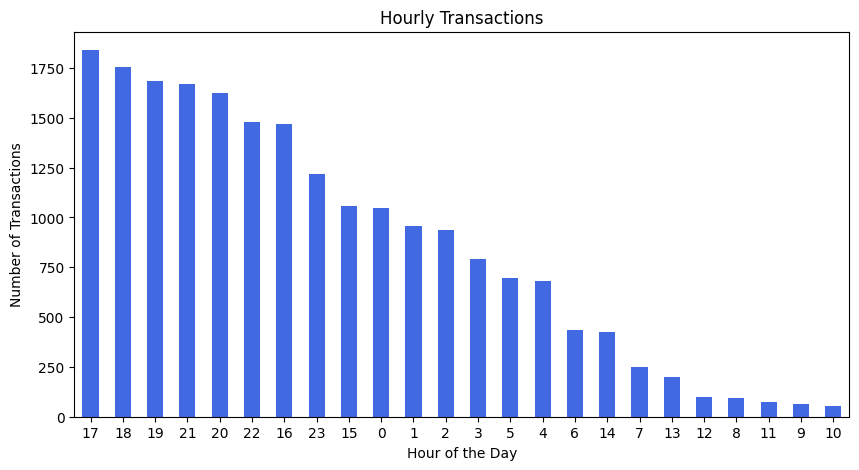

In [83]:
# most bussiest hour of the day
hourly_transactions = final_df[final_df['event'] == 'transaction'].groupby("hour").size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
hourly_transactions.plot(kind='bar', color="royalblue")
plt.title("Hourly Transactions")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.show()


##### General Observations About the Time-Series Analysis
I observed the following:
- The months of July and August were the bussiest month with most activities on the website and it reduces in the month of September.
- The Weekdays, were the days with the most activities from Monday to Wednesday and the number of activities reduced during the weekends.
- Also, activities increase from the afternoon to late evening around 17 hours and reduces from the 18 hours till the next morning around 11 hours before activities increases.

###### Top-10 Most Engaged Visitor


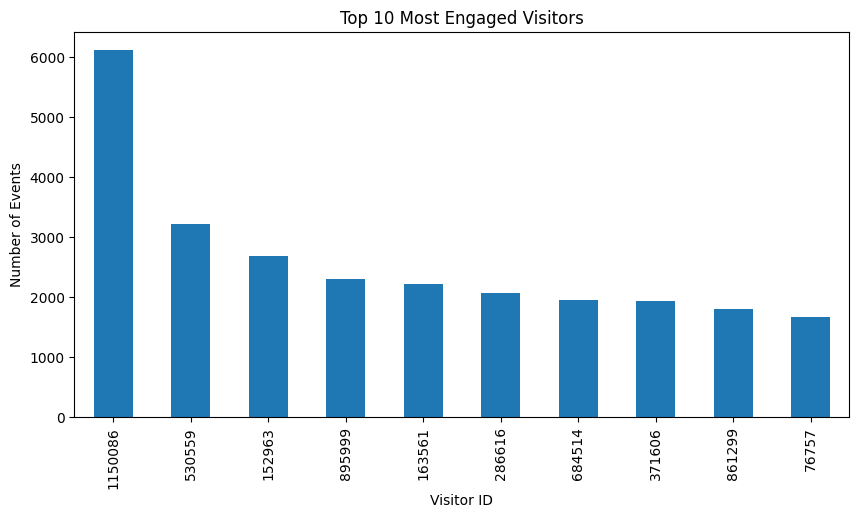

In [84]:
top_10_visitors = final_df.groupby('visitorid')['event'].count().nlargest(10)
plt.figure(figsize=(10, 5))
top_10_visitors.plot(kind='bar')
plt.title('Top 10 Most Engaged Visitors')
plt.xlabel('Visitor ID')
plt.ylabel('Number of Events')
plt.show()

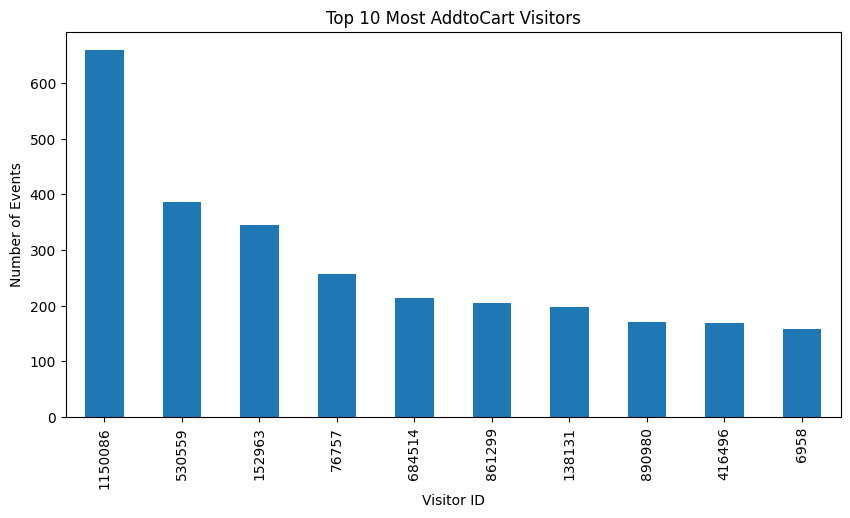

In [85]:
# Visitor with the most addtocarts
top_10_visitors = final_df[final_df['event'] == 'addtocart'].groupby('visitorid')['event'].count().nlargest(10)
plt.figure(figsize=(10, 5))
top_10_visitors.plot(kind='bar')
plt.title('Top 10 Most AddtoCart Visitors')
plt.xlabel('Visitor ID')
plt.ylabel('Number of Events')
plt.show()

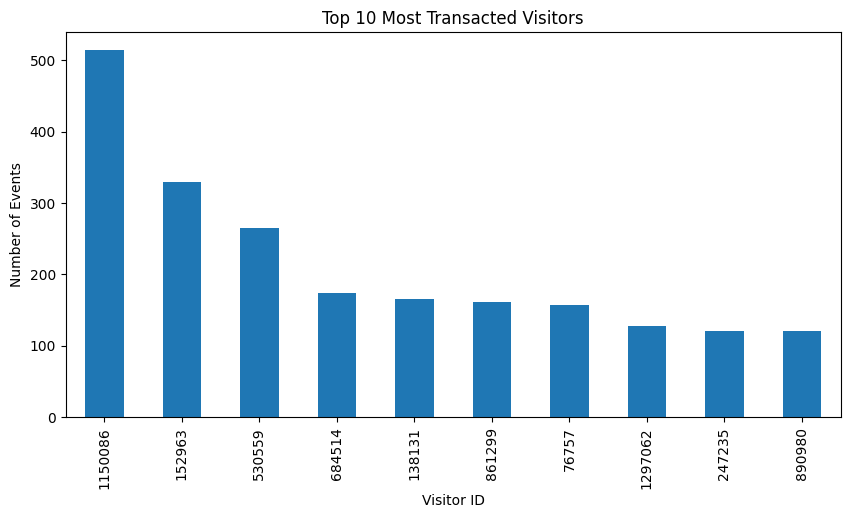

In [86]:
# Visitor with the most transactions
top_10_visitors = final_df[final_df['event'] == 'transaction'].groupby('visitorid')['event'].count().nlargest(10)
plt.figure(figsize=(10, 5))
top_10_visitors.plot(kind='bar')
plt.title('Top 10 Most Transacted Visitors')
plt.xlabel('Visitor ID')
plt.ylabel('Number of Events')
plt.show()

I observed that the visitor with visit ID 1150086 has the most views,addtocarts and transactions.

Further analysis will be done to know the particular products this visitor engaged with.

#### Bivariate Analysis


#####Event Type vs. Visitor Activity

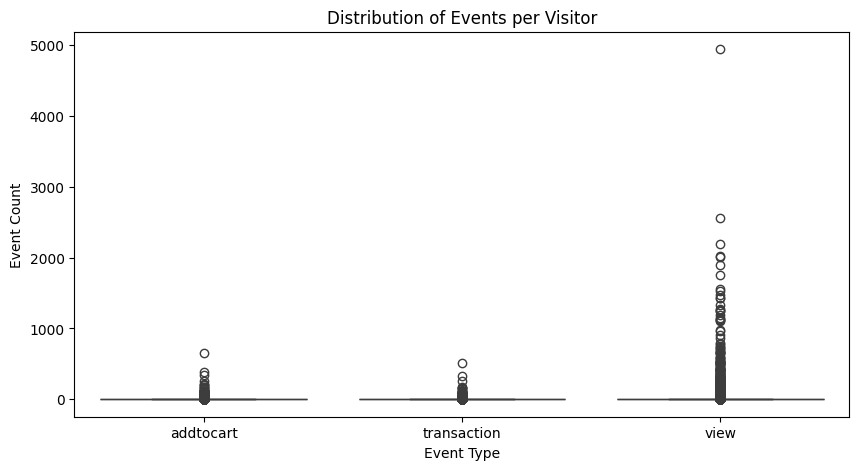

In [87]:
visitor_event_counts = final_df.groupby("visitorid")["event"].value_counts().unstack()
plt.figure(figsize=(10, 5))
sns.boxplot(data=visitor_event_counts)
plt.title("Distribution of Events per Visitor")
plt.xlabel("Event Type")
plt.ylabel("Event Count")
plt.show()


🔹 Insight: See if some visitors are more likely to transact, view, or add items to their cart.

##### Item Popularity: Views vs. (Transactions & Add to Cart)
- Objective: Identify whether high views lead to high add to carts and transactions.
- Approach:
- Scatter plot of views vs. transactions per item.
- Scatter plot of views vs. add to cart per item.




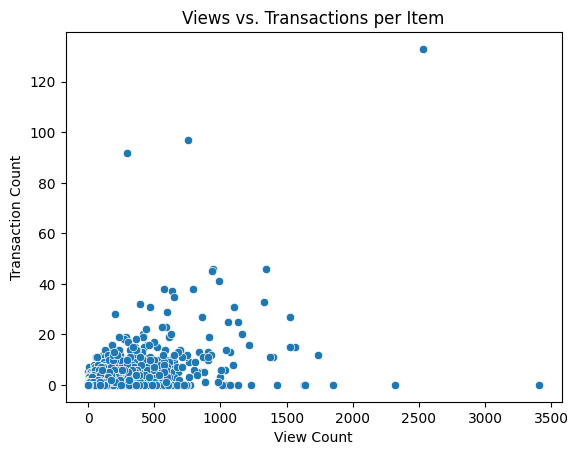

In [88]:
item_events = final_df.groupby(['itemid', 'event']).size().unstack(fill_value=0)
sns.scatterplot(x=item_events['view'], y=item_events['transaction'])

plt.title("Views vs. Transactions per Item")
plt.xlabel("View Count")
plt.ylabel("Transaction Count")
plt.show()


Insight:High views correlate with transactions, it may indicate that items with the most views has the higher possibility of being transacted.



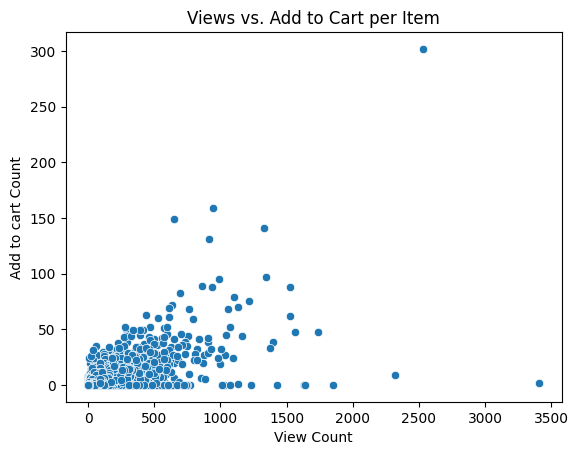

In [89]:
item_events = final_df.groupby(['itemid', 'event']).size().unstack(fill_value=0)
sns.scatterplot(x=item_events['view'], y=item_events['addtocart'])

plt.title("Views vs. Add to Cart per Item")
plt.xlabel("View Count")
plt.ylabel("Add to cart Count")
plt.show()


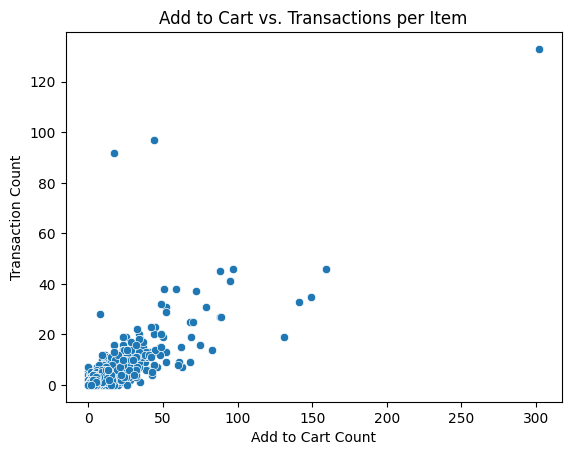

In [90]:
item_events = final_df.groupby(['itemid', 'event']).size().unstack(fill_value=0)
sns.scatterplot(x=item_events['addtocart'], y=item_events['transaction'])

plt.title("Add to Cart vs. Transactions per Item")
plt.xlabel("Add to Cart Count")
plt.ylabel("Transaction Count")
plt.show()

#### Activities Performed by the most active visitor

In [91]:
most_active_visitor = final_df[final_df["visitorid"] ==  1150086 ]
most_active_visitor

,visitorid,event,itemid,categoryid,description,parentid,month,day,dayname,hour,minute,second
datetime,,,,,,,,,,,,
2015-06-11 15:20:06,1150086,view,231726,790,n0.000,1492.0,6,11,Thursday,15,20,6
2015-06-11 15:24:48,1150086,view,427777,790,n0.000,1492.0,6,11,Thursday,15,24,48
2015-06-11 15:25:32,1150086,view,398115,790,n0.000,1492.0,6,11,Thursday,15,25,32
2015-06-11 15:26:43,1150086,addtocart,398115,790,n0.000,1492.0,6,11,Thursday,15,26,43
2015-06-11 15:28:45,1150086,transaction,398115,790,n0.000,1492.0,6,11,Thursday,15,28,45
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-17 02:42:14,1150086,view,157621,790,n0.000,1492.0,9,17,Thursday,2,42,14
2015-09-17 02:42:27,1150086,view,25383,790,n0.000,1492.0,9,17,Thursday,2,42,27
2015-09-17 02:49:47,1150086,view,270534,790,n0.000,1492.0,9,17,Thursday,2,49,47


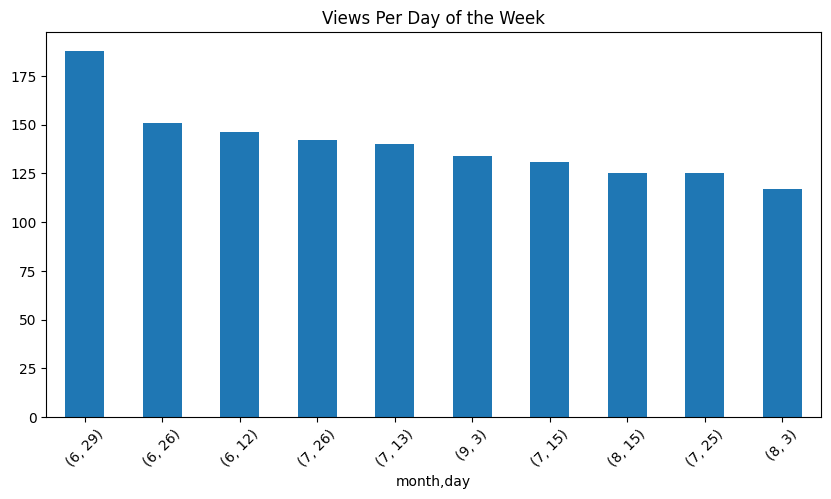

In [92]:
# Number of views per day by the day by the most active visitor
views_by_dayname = most_active_visitor[most_active_visitor['event'] == 'view'].groupby(['month','day']).size().sort_values(ascending=False)
views_by_dayname = views_by_dayname.head(10)
plt.figure(figsize=(10, 5))
views_by_dayname.plot(kind='bar')
plt.title('Views Per Day of the Week')
plt.xticks(rotation = 45)
plt.show()


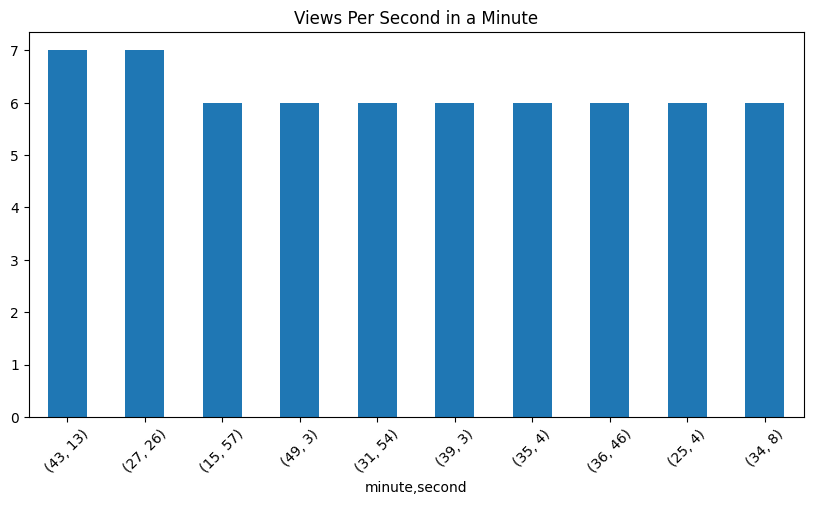

In [93]:
# Number of views per second
views_per_second = most_active_visitor[most_active_visitor['event'] == 'view'].groupby(['minute','second']).size().sort_values(ascending=False)
views_per_second = views_per_second.head(10)
plt.figure(figsize=(10, 5))
views_per_second.plot(kind='bar')
plt.title('Views Per Second in a Minute')
plt.xticks(rotation = 45)
plt.show()


- This visitor might be a bot, with about 7-6 views is a potential bot which must be removed after further analysis.
- This suggest the presence of bot users coming to the platform.

In [94]:
# Convert itemid to int64 dtype
final_df["itemid"] = final_df["itemid"].astype(int)

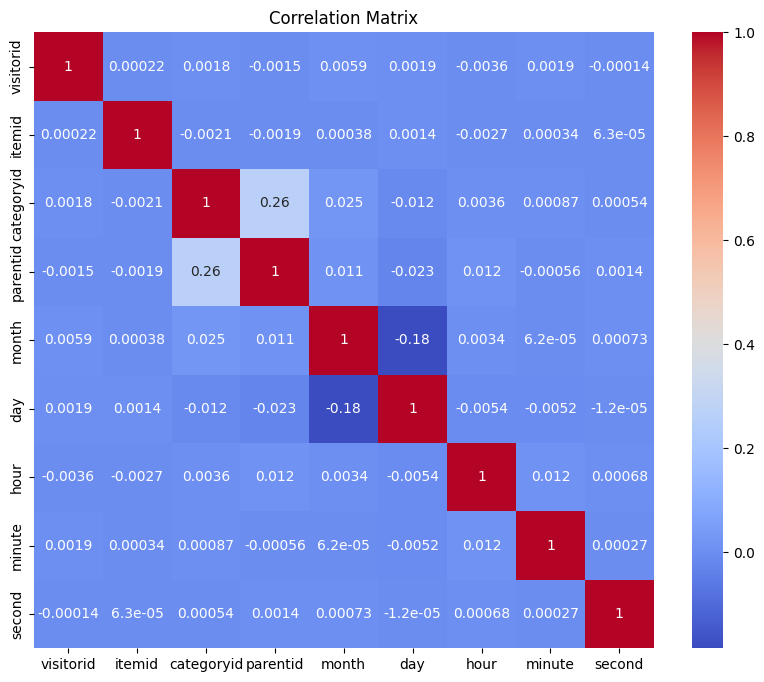

In [95]:
# Correlation Matrrix
numerical_columns = final_df.select_dtypes("number").columns
corr_matrix = final_df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

#### Answering Analytical Questions

1.Do the most viewed items also have the highest add-to-cart and transaction counts?

In [96]:
# Count occurrences of each event type per item
top_items = final_df.groupby(['itemid', 'event']).size().unstack(fill_value=0)

# Get the top 10 items for each event type
top_views = top_items['view'].nlargest(10)
top_addtocart = top_items['addtocart'].nlargest(10)
top_transactions = top_items['transaction'].nlargest(10)

# Combine results into a single DataFrame for comparison
top_items_df = pd.DataFrame({
    "Top Viewed Items": top_views.index,
    "View Count": top_views.values,
    "Top Add to Cart Items": top_addtocart.index,
    "Add to Cart Count": top_addtocart.values,
    "Top Transaction Items": top_transactions.index,
    "Transaction Count": top_transactions.values
})
top_items_df

,Top Viewed Items,View Count,Top Add to Cart Items,Add to Cart Count,Top Transaction Items,Transaction Count
0,187946,3409,461686,302,461686,133
1,461686,2534,312728,159,119736,97
2,5411,2321,409804,149,213834,92
3,370653,1854,320130,141,7943,46
4,219512,1736,29196,131,312728,46
5,298009,1640,7943,97,445351,45
6,96924,1631,48030,95,48030,41
7,309778,1565,441852,89,248455,38
8,257040,1529,257040,88,420960,38
9,384302,1527,445351,88,17478,37


Can be seen from the above dataframe, that the most viewed item wasn't the most add to cart neither the most transacted item. This implies, that transacted item doesn't depend on the number of views.

2. Does a visitor number of views for a certain item influences his/decision to add the item to cart?

Correlation between views and add-to-cart: 0.65


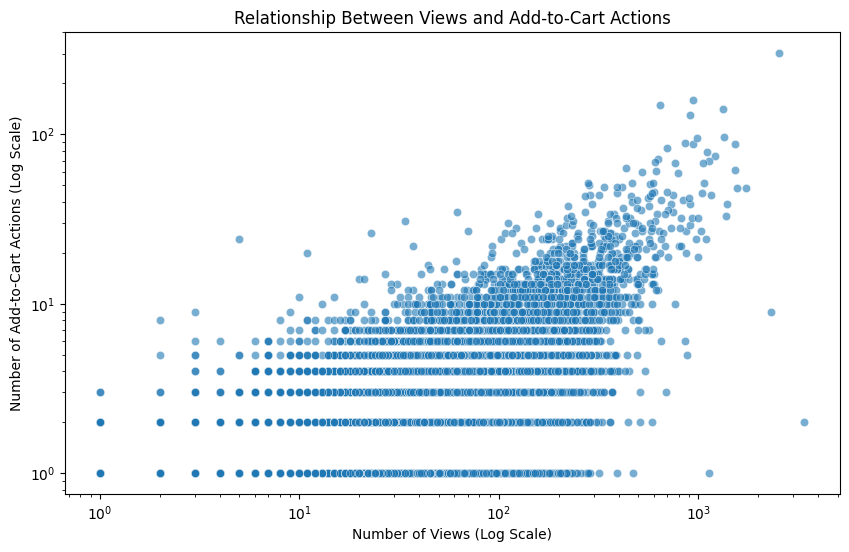

In [97]:
# Convert itemid to string
final_df["itemid"] = final_df["itemid"].astype(str)

# Aggregate number of views and add-to-cart actions per item
item_conversion = final_df.groupby("itemid")["event"].value_counts().unstack(fill_value=0)
# Ensure the required columns exist
if "view" in item_conversion.columns and "addtocart" in item_conversion.columns:
    # Compute conversion rate (add-to-cart / views)
    item_conversion["conversion_rate"] = item_conversion["addtocart"] / item_conversion["view"]

   # Compute correlation between views and add-to-cart actions
    correlation = item_conversion["view"].corr(item_conversion["addtocart"])
    print(f"Correlation between views and add-to-cart: {correlation:.2f}")

    # Scatter plot to visualize relationship
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=item_conversion["view"], y=item_conversion["addtocart"], alpha=0.6)
    plt.xscale("log")  # Log scale for better visibility
    plt.yscale("log")
    plt.title("Relationship Between Views and Add-to-Cart Actions")
    plt.xlabel("Number of Views (Log Scale)")
    plt.ylabel("Number of Add-to-Cart Actions (Log Scale)")
    plt.show()


There is a positive correlation between viewed items and add to cart items. This insight will inform my decision in building the recommendation system algorithm

3. What are the most transacted item?

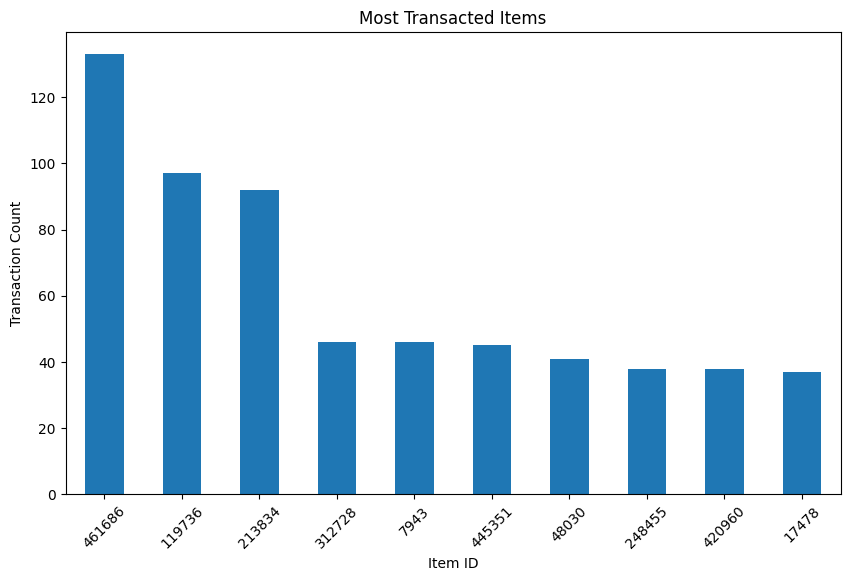

In [98]:
most_transacted_category = final_df.groupby("itemid")["event"].value_counts().unstack(fill_value=0)["transaction"].sort_values(ascending=False).head(10)
most_transacted_category.plot(kind="bar", figsize=(10, 6))
plt.title("Most Transacted Items")
plt.xlabel("Item ID")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()

4. Who are the abnormal users - (bots)?

In [99]:
# Group by user and exact second
abnormal_users = pd.pivot_table(final_df, index=["visitorid","month","day","hour","minute","second"], values="event",aggfunc="count")
# Sort in descending order
abnormal_users = abnormal_users.sort_values(by="event", ascending=False)
# Display top 10 potential bots
abnormal_users.head(10)

event
visitorid month day hour minute second       
761482    5     14  16   40     13         25
                    18   5      24         19
974226    7     15  17   3      16         18
765630    6     23  0    6      2          17
412611    8     10  18   36     56         16
822310    6     11  20   35     46         13
1197343   8     13  19   37     25         12
478054    5     27  21   53     42         11
565903    7     25  18   39     52         11
48820     7     10  1    13     55         11

In [100]:
# number of potential bot users
bot_users = abnormal_users[abnormal_users["event"] > 1]
print(f"Number of potential bot users: {bot_users.shape[0]}")

Number of potential bot users: 5314


In [101]:
bot_users.groupby(["visitorid","month","day","hour","minute","second"]).size().sort_values(ascending=False)

,,,,,,0
visitorid,month,day,hour,minute,second,
1407093,5,7,0,29,50,1
172,8,15,1,29,1,1
1400296,5,17,15,31,5,1
1400219,7,26,0,37,32,1
1398978,8,3,19,2,55,1
...,...,...,...,...,...,...
3926,6,17,0,40,40,1
3465,6,16,1,37,44,1
3242,5,24,13,53,35,1


The users with higher number views within a second are the abnormal users and they add a lot of noise to my analysis.
- Even a faster visitor can take 1-2 seconds per item to scan,scroll or interact.
- Bots can scrape hundreds or thousands of items per second.
- They don’t wait for images to load or for UI interactions.

#### Next Steps
- >2 views per second: Likely automated bot activity.
- 3-5 views per second: Almost certainly a scripted crawler.
- 10+ views per second: Highly suspicious and likely an aggressive web scraper.
- Therefore a treshold view of 2 will be set and during the data preparation phase, I will remove all the visitors whose views exceed the treshold.

5. What are the most add to cart items?

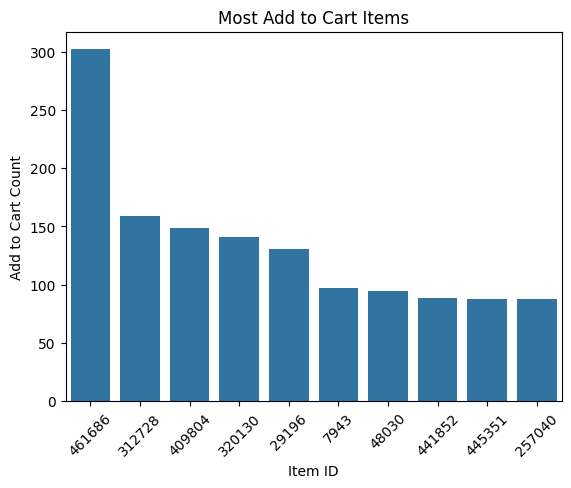

In [102]:
most_addtocart_item = final_df.groupby("itemid")["event"].value_counts().unstack(fill_value=0)["addtocart"].sort_values(ascending=False).head(10)
sns.barplot(x=most_addtocart_item.index, y=most_addtocart_item.values)
plt.title("Most Add to Cart Items")
plt.xlabel("Item ID")
plt.ylabel("Add to Cart Count")
plt.xticks(rotation=45)
plt.show()

6. Which particular time of the day has the most transactions?

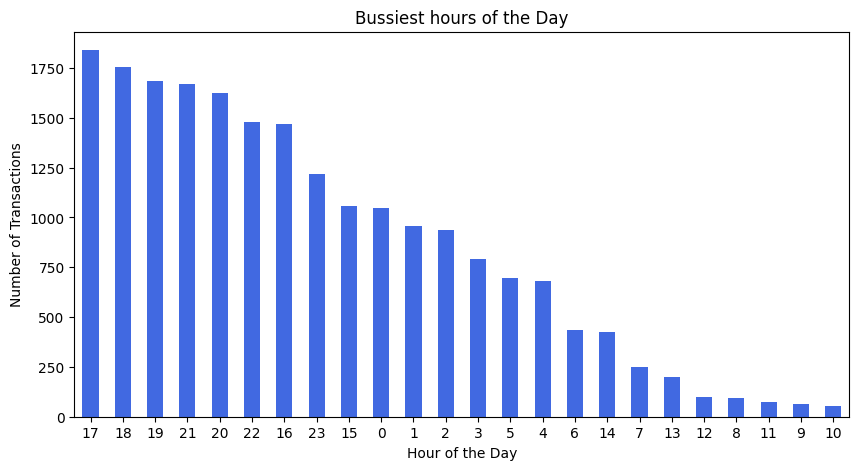

In [103]:
hourly_transactions = final_df[final_df['event'] == 'transaction'].groupby("hour").size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
hourly_transactions.plot(kind='bar', color="royalblue")
plt.title("Bussiest hours of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.show()

Can be observed that most transactions happens in the ending hours(evening time) of the day. From 17 hours to 23 hours the transactions peak and the transactions reduce from 0 hours to 10 hours.

7. What is the view to "add to cart" conversion rate?

In [104]:
total_views = final_df[final_df["event"] == "view"].shape[0]
total_add_to_cart = final_df[final_df["event"] == "addtocart"].shape[0]

overall_conversion_rate = (total_add_to_cart / total_views) * 100

print(f"Overall View-to-Add-to-Cart Conversion Rate: {overall_conversion_rate:.2f}%")


Overall View-to-Add-to-Cart Conversion Rate: 2.93%


- Insight: From the test above, there is a very low view to add-to-cart conversion rate which must be look at and find ways to improve view to addtocart conversion rate.

8. What is the "addtocart" to "transactions" conversion rate?

In [105]:
total_add_to_cart = final_df[final_df["event"] == "addtocart"].shape[0]
total_transactions = final_df[final_df["event"] == "transaction"].shape[0]

overall_conversion_rate = (total_transactions/ total_add_to_cart) * 100

print(f"Overall Add-to-Cart-Transaction Conversion Rate: {overall_conversion_rate:.2f}%")


Overall Add-to-Cart-Transaction Conversion Rate: 33.00%


- Insight: Although the addtocart-transaction conversion rate is more than the view-addtocart conversion rate, but is not good enough which this recommendation system aims to improve.

## Data Preparation

In [106]:
# load first few rows of data
final_df.head()

,visitorid,event,itemid,categoryid,description,parentid,month,day,dayname,hour,minute,second
datetime,,,,,,,,,,,,
2015-05-03 03:00:04,693516,addtocart,297662,790,n0.000,1492.0,5,3,Sunday,3,0,4
2015-05-03 03:00:11,829044,view,60987,186,769062,865.0,5,3,Sunday,3,0,11
2015-05-03 03:00:24,1125936,view,33661,790,n0.000,1492.0,5,3,Sunday,3,0,24
2015-05-03 03:00:26,693516,view,297662,790,n0.000,1492.0,5,3,Sunday,3,0,26
2015-05-03 03:00:27,1149227,view,29757,790,n0.000,1492.0,5,3,Sunday,3,0,27


In [107]:
def remove_bots(df: pd.DataFrame, threshold: int = 1):
    """
    Removes abnormal users (bots) based on excessive event frequency.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing user activity.
        threshold (int): The number of events per minute-second threshold to classify as a bot.

    Returns:
        pd.DataFrame: Cleaned DataFrame with bots removed.
    """
    # Group by minute, second, and visitorid, then count events
    visitor_activity = df.groupby(["month","day","hour","minute","second","visitorid"])["event"].count()

    # Identify visitor IDs with high activity
    bot_visitors = visitor_activity[visitor_activity > threshold].index.get_level_values("visitorid").unique()

    # Remove bot users
    df_cleaned = df[~df["visitorid"].isin(bot_visitors)]

    return df_cleaned


In [108]:
cleaned_df = remove_bots(final_df)
cleaned_df.shape

(2055159, 12)

In [109]:
final_df.shape

(2212649, 12)

2055159 which shows 157,490 of potential bots that has been taken from the final dataframe

In [110]:
# load first five rows of cleaned_df
cleaned_df.head()

,visitorid,event,itemid,categoryid,description,parentid,month,day,dayname,hour,minute,second
datetime,,,,,,,,,,,,
2015-05-03 03:00:04,693516,addtocart,297662,790,n0.000,1492.0,5,3,Sunday,3,0,4
2015-05-03 03:00:11,829044,view,60987,186,769062,865.0,5,3,Sunday,3,0,11
2015-05-03 03:00:24,1125936,view,33661,790,n0.000,1492.0,5,3,Sunday,3,0,24
2015-05-03 03:00:26,693516,view,297662,790,n0.000,1492.0,5,3,Sunday,3,0,26
2015-05-03 03:00:27,1149227,view,29757,790,n0.000,1492.0,5,3,Sunday,3,0,27


In [111]:
# check for duplicates
cleaned_df.duplicated().sum()

np.int64(0)

In [112]:
# count number of views per visitor
visitor_view_counts = cleaned_df[cleaned_df["event"] == "view"].groupby(["visitorid","day","hour","minute","second"]).size().sort_values(ascending=False)
visitor_view_counts

,,,,,0
visitorid,day,hour,minute,second,
1119917,24,18,50,58,2
856874,3,21,29,15,2
938445,3,20,18,16,1
938444,23,20,27,22,1
938443,2,4,53,38,1
...,...,...,...,...,...
470401,18,17,1,56,1
470399,5,4,29,19,1
470398,30,17,40,3,1


#### Mapping Implicit Feedback
Implicit feedback captures user behavior instead of direct ratings. It includes actions like clicks, views, purchases, and addtocarts, which indicate interest but are not explicitly labeled by users.

- Example:
  - A user watches a movie but doesn’t rate it. We assume they liked it to some extent.
  - A user adds an item to their cart but doesn’t buy it. This still signals some level of interest.

- View (view) → The user looked at the item, but no strong interest is confirmed.
- Add to Cart (addtocart) → The user is considering buying the item. Stronger intent.
- Transaction (transaction) → The user bought the item. This is the strongest signal.

In [113]:
# Mapping Implicit Feedback in the events column
cleaned_df["event"] = cleaned_df["event"].map({
    "view": 1,
    "addtocart": 2,
    "transaction": 3
})

In [114]:
# strip n in the values in the description column
cleaned_df["description"] = cleaned_df["description"].str.strip("n")

In [115]:
# Convert description to numeric, forcing errors to NaN
cleaned_df["description"] = pd.to_numeric(cleaned_df["description"], errors="coerce")

In [116]:
cleaned_df.head()

,visitorid,event,itemid,categoryid,description,parentid,month,day,dayname,hour,minute,second
datetime,,,,,,,,,,,,
2015-05-03 03:00:04,693516,2,297662,790,0.0,1492.0,5,3,Sunday,3,0,4
2015-05-03 03:00:11,829044,1,60987,186,769062.0,865.0,5,3,Sunday,3,0,11
2015-05-03 03:00:24,1125936,1,33661,790,0.0,1492.0,5,3,Sunday,3,0,24
2015-05-03 03:00:26,693516,1,297662,790,0.0,1492.0,5,3,Sunday,3,0,26
2015-05-03 03:00:27,1149227,1,29757,790,0.0,1492.0,5,3,Sunday,3,0,27


In [117]:
# reset index
cleaned_df.reset_index(inplace=True)

In [118]:
cleaned_df.head()

,datetime,visitorid,event,itemid,categoryid,description,parentid,month,day,dayname,hour,minute,second
0,2015-05-03 03:00:04,693516,2,297662,790,0.0,1492.0,5,3,Sunday,3,0,4
1,2015-05-03 03:00:11,829044,1,60987,186,769062.0,865.0,5,3,Sunday,3,0,11
2,2015-05-03 03:00:24,1125936,1,33661,790,0.0,1492.0,5,3,Sunday,3,0,24
3,2015-05-03 03:00:26,693516,1,297662,790,0.0,1492.0,5,3,Sunday,3,0,26
4,2015-05-03 03:00:27,1149227,1,29757,790,0.0,1492.0,5,3,Sunday,3,0,27


#### An Algorithm to Predict Add to Cart Activities Based On View Events

##### Step By Step Approach
- Filter data for relevant events
- Match "Add-to-cart" items with previously viewed items
- Feature Engineering
  - (a) Time-based Preference
    - If a user views an item multiple times before adding it, it likely interests them.
    - How long before an "add-to-cart" event did they view the item?
  - (b) Most Viewed Categories
    - Users often add items to their cart from a category they frequently viewed.
  - (c) Item Popularity
    - From my EDA, items with high view counts tend to be added more frequently.
- Train Model
  - Predict Category of addtocart items based on views

###### 1. Filter data for relevant events

In [119]:
# Separate view and add to cart events
view_df = cleaned_df[cleaned_df["event"] == 1]
addtocart_df = cleaned_df[cleaned_df["event"] == 2]

##### 2. Match "Add-to-cart" items with previously viewed items

In [120]:
# Merge add to cart and view events based on visitor id
merged_df = pd.merge(addtocart_df, view_df, on=["visitorid"],suffixes=("_addtocart","_view"))

merged_df.head()

,datetime_addtocart,visitorid,event_addtocart,itemid_addtocart,categoryid_addtocart,description_addtocart,parentid_addtocart,month_addtocart,day_addtocart,dayname_addtocart,...,itemid_view,categoryid_view,description_view,parentid_view,month_view,day_view,dayname_view,hour_view,minute_view,second_view
0,2015-05-03 03:00:04,693516,2,297662,790,0.0,1492.0,5,3,Sunday,...,297662,790,0.0,1492.0,5,3,Sunday,3,0,26
1,2015-05-03 03:00:29,693516,2,297662,790,0.0,1492.0,5,3,Sunday,...,297662,790,0.0,1492.0,5,3,Sunday,3,0,26
2,2015-05-03 03:01:25,979664,2,338222,790,0.0,1492.0,5,3,Sunday,...,91998,790,0.0,1492.0,5,3,Sunday,3,2,34
3,2015-05-03 03:01:25,979664,2,338222,790,0.0,1492.0,5,3,Sunday,...,355594,790,0.0,1492.0,5,3,Sunday,3,2,44
4,2015-05-03 03:01:25,979664,2,338222,790,0.0,1492.0,5,3,Sunday,...,430965,888,1314085.0,866.0,5,3,Sunday,3,3,51


##### 3. Feature Enginering

In [121]:
# calculate time difference between view event and addtocart event
merged_df["time_diff"] = merged_df["datetime_addtocart"] - merged_df["datetime_view"]

In [122]:
# Count views per category by visitor
category_preferences = view_df.groupby(["visitorid","categoryid"]).size().reset_index(name="view_count")

# Merge back to merged_df
merged_df = pd.merge(merged_df, category_preferences, on=["visitorid"], how="left")

In [123]:
# Count total views per item
item_view_counts = view_df.groupby("itemid")["visitorid"].count().reset_index(name="total_views")

# Merge back to merged_df
merged_df = pd.merge(merged_df, item_view_counts, left_on="itemid_addtocart", right_on="itemid", how="left")
merged_df

,datetime_addtocart,visitorid,event_addtocart,itemid_addtocart,categoryid_addtocart,description_addtocart,parentid_addtocart,month_addtocart,day_addtocart,dayname_addtocart,...,day_view,dayname_view,hour_view,minute_view,second_view,time_diff,categoryid,view_count,itemid,total_views
0,2015-05-03 03:00:04,693516,2,297662,790,0.0,1492.0,5,3,Sunday,...,3,Sunday,3,0,26,-1 days +23:59:38,790,1,297662,59.0
1,2015-05-03 03:00:29,693516,2,297662,790,0.0,1492.0,5,3,Sunday,...,3,Sunday,3,0,26,0 days 00:00:03,790,1,297662,59.0
2,2015-05-03 03:01:25,979664,2,338222,790,0.0,1492.0,5,3,Sunday,...,3,Sunday,3,2,34,-1 days +23:58:51,790,7,338222,48.0
3,2015-05-03 03:01:25,979664,2,338222,790,0.0,1492.0,5,3,Sunday,...,3,Sunday,3,2,34,-1 days +23:58:51,888,2,338222,48.0
4,2015-05-03 03:01:25,979664,2,338222,790,0.0,1492.0,5,3,Sunday,...,3,Sunday,3,2,44,-1 days +23:58:41,790,7,338222,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271671,2015-09-18 01:44:24,62004,2,312594,888,1314085.0,866.0,9,18,Friday,...,18,Friday,1,41,52,0 days 00:02:32,438,1,312594,168.0
4271672,2015-09-18 01:44:24,62004,2,312594,888,1314085.0,866.0,9,18,Friday,...,18,Friday,1,41,52,0 days 00:02:32,790,2,312594,168.0
4271673,2015-09-18 01:44:24,62004,2,312594,888,1314085.0,866.0,9,18,Friday,...,18,Friday,1,41,52,0 days 00:02:32,888,3,312594,168.0
4271674,2015-09-18 02:45:20,1108521,2,134455,71,376905.0,1579.0,9,18,Friday,...,18,Friday,2,45,38,-1 days +23:59:42,71,1,134455,9.0


In [124]:
merged_df.isna().sum()

,0
datetime_addtocart,0
visitorid,0
event_addtocart,0
itemid_addtocart,0
categoryid_addtocart,0
description_addtocart,519297
parentid_addtocart,0
month_addtocart,0
day_addtocart,0
dayname_addtocart,0


In [125]:
# Drop the null values in the merged_df dataset
merged_df.dropna(inplace=True)

In [126]:
# Checked the final shape of merged_df
merged_df.shape

(3268019, 30)

##### 4. Build the Model

In [127]:
# X(input) and y(output) split

# set categoryid as target varialble
y = merged_df["categoryid_addtocart"]

features = ["view_count","total_views","time_diff"]
X = merged_df[features]

##### Train-Test Split

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
y_train

,categoryid_addtocart
1564874,790
3925829,790
2008114,790
1926353,1058
457204,790
...,...
2187684,980
3042153,790
2888470,993
3610211,790


In [130]:
le = LabelEncoder()
le.fit(np.concatenate((y_train, y_test)))  # Fit on both y_train and y_test
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)


In [131]:
for col in X_train.select_dtypes(include=['timedelta64']).columns:
    X_train[col] = X_train[col].dt.total_seconds()  # Convert to seconds
    X_test[col] = X_test[col].dt.total_seconds()


In [132]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

In [133]:
# Train knn model
model = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
model.fit(X_train, y_train_encoded)

KNeighborsClassifier(n_jobs=-1)

In [134]:
# Predict on test data
y_pred = model.predict(X_test)

In [135]:
y_pred = le.inverse_transform(y_pred)


In [136]:
np.unique(y_pred)

array([   0,    1,    6,   10,   15,   19,   30,   32,   34,   36,   37,
         38,   40,   42,   45,   46,   47,   51,   59,   62,   64,   66,
         71,   72,   74,   83,   84,   86,   87,   93,   99,  101,  105,
        106,  107,  112,  120,  122,  124,  126,  141,  142,  152,  153,
        159,  161,  173,  176,  178,  185,  186,  194,  202,  210,  212,
        214,  215,  217,  221,  225,  227,  230,  235,  238,  241,  242,
        246,  251,  256,  257,  274,  275,  278,  281,  284,  286,  293,
        296,  297,  302,  311,  316,  323,  325,  327,  332,  333,  335,
        336,  344,  346,  348,  349,  354,  355,  360,  364,  369,  372,
        373,  377,  381,  382,  392,  397,  403,  404,  405,  406,  407,
        408,  409,  415,  420,  421,  422,  434,  438,  445,  451,  453,
        456,  457,  458,  464,  467,  468,  470,  478,  480,  484,  487,
        490,  491,  495,  496,  497,  498,  503,  504,  505,  506,  509,
        510,  513,  516,  521,  529,  545,  546,  5

In [137]:
# Evaluate
print("Model Accuracy:", accuracy_score(y_test,y_pred))

Model Accuracy: 0.9322035972852063


## Modeling and Evaluation
My recommendation model will be built based on these approaches.
- Content-Based Filtering – recommending items based on item properties.
- Collaborative Filtering – using user interactions (views, add-to-cart, transactions).
- Hybrid Filtering – combining both approaches.


In [138]:
cleaned_df.head()

,datetime,visitorid,event,itemid,categoryid,description,parentid,month,day,dayname,hour,minute,second
0,2015-05-03 03:00:04,693516,2,297662,790,0.0,1492.0,5,3,Sunday,3,0,4
1,2015-05-03 03:00:11,829044,1,60987,186,769062.0,865.0,5,3,Sunday,3,0,11
2,2015-05-03 03:00:24,1125936,1,33661,790,0.0,1492.0,5,3,Sunday,3,0,24
3,2015-05-03 03:00:26,693516,1,297662,790,0.0,1492.0,5,3,Sunday,3,0,26
4,2015-05-03 03:00:27,1149227,1,29757,790,0.0,1492.0,5,3,Sunday,3,0,27


In [139]:
cleaned_df.columns

Index(['datetime', 'visitorid', 'event', 'itemid', 'categoryid', 'description',
       'parentid', 'month', 'day', 'dayname', 'hour', 'minute', 'second'],
      dtype='object')

In [140]:
# calculate null values
cleaned_df.isna().sum()

,0
datetime,0
visitorid,0
event,0
itemid,0
categoryid,0
description,401403
parentid,0
month,0
day,0
dayname,0


In [141]:
# Fill Nulls with zeros values
cleaned_df.fillna(0,inplace=True)

In [142]:
# confirm changes
cleaned_df.isna().sum()

,0
datetime,0
visitorid,0
event,0
itemid,0
categoryid,0
description,0
parentid,0
month,0
day,0
dayname,0


#### Content-Based Filtering
Content-based filtering recommends items similar to those a user has interacted with, based on features like categoryid,parentid and description etc.

In [143]:
# select important features
important_features = ["itemid","categoryid","parentid","description"]
df = cleaned_df[important_features]
df.head()

,itemid,categoryid,parentid,description
0,297662,790,1492.0,0.0
1,60987,186,865.0,769062.0
2,33661,790,1492.0,0.0
3,297662,790,1492.0,0.0
4,29757,790,1492.0,0.0


#### Train-test Split

In [144]:
df_train, df_test = train_test_split(df,test_size=0.2, random_state=42)

In [145]:
# Keep item IDs separately
df_train_ids = df_train["itemid"].reset_index(drop=True)
df_test_ids = df_test["itemid"].reset_index(drop=True)

In [146]:
# Drop itemid from features
df_train_features = csr_matrix(df_train.drop(columns=["itemid"]).astype(np.int64).values)
df_test_features = csr_matrix(df_test.drop(columns=["itemid"]).astype(np.int64).values)


##### Build Item Similarity with K-Nearest Neighbors

In [147]:
# Train a KNN model with cosine similarity
knn_model = NearestNeighbors(n_neighbors=10, metric="cosine", algorithm="auto")
knn_model.fit(df_train_features)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [148]:
df_test_ids.head()

,itemid
0,82278
1,160975
2,141277
3,232189
4,293038


In [149]:

# Function to recommend similar items
def recommend_items(itemid, knn_model, df_ids, df_features, top_n=5):
    # Find the index of the item in df_ids
    if itemid not in df_ids.values:
        return f"Item ID {itemid} not found in training data."

    item_index = df_ids[df_ids == itemid].index[0]  # Get row number

    # Get nearest neighbors
    distances, indices = knn_model.kneighbors(df_features[item_index], n_neighbors=top_n+1)

    # Get item IDs of recommended items (excluding itself)
    recommended_item_ids = df_ids.iloc[indices[0][1:]].tolist()

    return recommended_item_ids

# Recommend similar items for a given itemid
itemid_to_recommend = 441668
recommendations = recommend_items(itemid_to_recommend, knn_model, df_train_ids, df_train_features)

print("Recommended items:", recommendations)

Recommended items: Item ID 441668 not found in training data.


#### Make Recommendations on the test data

In [150]:
# def recommend_items_for_test(knn_model, df_train_ids, df_test_ids, df_test_features, top_n=5):
#     # Get nearest neighbors for all test data
#     distances, indices = knn_model.kneighbors(df_test_features, n_neighbors=top_n+1)

#     # Create a dictionary mapping test item IDs to their recommended items
#     recommendations_dict = {
#         test_item_id: df_train_ids.iloc[indices[i][1:]].tolist()  # Skip the first (itself)
#         for i, test_item_id in enumerate(df_test_ids)
#     }

#     return recommendations_dict

# # Get recommendations for test set (optimized)
# test_recommendations = recommend_items_for_test(knn_model, df_train_ids, df_test_ids, df_test_features)


In [ ]:
def recommend_items_for_test(knn_model, df_train_ids, df_test_ids, df_test_features, top_n=5, batch_size=500):
    recommendations_dict = {}

    # Process in chunks
    num_samples = df_test_features.shape[0]

    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)  # Ensure we don't go out of bounds
        chunk_features = df_test_features[start:end]
        chunk_test_ids = df_test_ids[start:end]

        # Get nearest neighbors for the batch
        distances, indices = knn_model.kneighbors(chunk_features, n_neighbors=top_n+1)

        # Map test item IDs to their recommended items (excluding itself)
        for i, test_item_id in enumerate(chunk_test_ids):
            recommendations_dict[test_item_id] = df_train_ids.iloc[indices[i][1:]].tolist()  # Exclude the first (itself)

    return recommendations_dict

# Get recommendations for test set with chunking (optimized)
test_recommendations = recommend_items_for_test(knn_model, df_train_ids, df_test_ids, df_test_features, batch_size=1000)


#### Model Evaluation

In [ ]:
def precision_recall_at_k(test_recommendations, df_test, df_train, k=5):
    precision_list = []
    recall_list = []

    for test_item, recommended_items in test_recommendations.items():
        # Get the actual category of test item
        actual_category = df_test[df_test["itemid"] == test_item]["categoryid"].values[0]

        # Get categories of recommended items
        recommended_categories = df_train[df_train["itemid"].isin(recommended_items)]["categoryid"].values

        # Count how many recommended items have the same category
        relevant_recommendations = sum(recommended_categories == actual_category)

        # Precision = Relevant items / Recommended items
        precision = relevant_recommendations / k

        # Recall = Relevant items / Total relevant items (assume all items in the category are relevant)
        total_relevant = (df_train["categoryid"] == actual_category).sum()
        recall = relevant_recommendations / total_relevant if total_relevant > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)

    # Compute mean precision and recall
    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)

    return mean_precision, mean_recall

# Evaluate the model
precision, recall = precision_recall_at_k(test_recommendations, df_test, df_train, k=5)
print(f"Precision@5: {precision:.4f}, Recall@5: {recall:.4f}")


#### Collaborative Filtering
Collaborative filtering works by recommending items based on user behavior, either using user-item interactions (User-Based CF) or similarities between items (Item-Based CF).

In [ ]:
# Engineer features for collaborative filtering
cleaned_df["dayname"] = cleaned_df["dayname"].astype("category").cat.codes  # Convert Monday-Sunday to numbers 0-6
cleaned_df["days_since_interaction"] = (cleaned_df["datetime"].max() - cleaned_df["datetime"]).dt.days
cleaned_df["time_weight"] = 1 / (1 + cleaned_df["days_since_interaction"])


In [ ]:
# Define features
collaborative_df = cleaned_df[["visitorid", "itemid", "event", "categoryid", "parentid", "description", "dayname", "time_weight"]]


In [ ]:
# Split dataset into train and test sets
df_train, df_test = train_test_split(collaborative_df, test_size=0.2, random_state=42)

print("Train shape:", df_train.shape, "Test shape:", df_test.shape)

In [ ]:

# Convert to sparse matrices
df_train_sparse = csr_matrix(df_train.drop(columns=["visitorid", "itemid"]).astype(np.float64).values)
df_test_sparse = csr_matrix(df_test.drop(columns=["visitorid", "itemid"]).astype(np.fl

In [ ]:
# Train KNN model
knn_model = NearestNeighbors(n_neighbors=10, metric="cosine", algorithm="auto")
knn_model.fit(df_train_sparse)


#### Train on ALS(Alternating LeastSquares) Models

In [ ]:
# # Create user-item interaction matrix with time_weight
# user_item_matrix = cleaned_df.pivot(index="visitorid", columns="itemid", values="time_weight").fillna(0)

# # Convert to sparse format
# user_item_sparse = csr_matrix(user_item_matrix)

# # Train ALS model
# als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=10)
# als_model.fit(user_item_sparse)

In [ ]:
# Function to recommend items using KNN
def recommend_items_knn(user_id, df, knn_model, df_features, top_n=5):
    # Find the index of the user in the original DataFrame
    user_rows = df[df["visitorid"] == user_id]

    if user_rows.empty:
        print(f"User {user_id} not found in training data.")
        return []

    user_idx = user_rows.index[0]  # Get index from DataFrame

    # Get similar users/items
    distances, indices = knn_model.kneighbors(df_features[user_idx], n_neighbors=top_n+1)

    # Extract recommended item indices (excluding the first one which is the query item)
    recommended_items = [df.iloc[i]["itemid"] for i in indices[0][1:]]

    return recommended_items

In [ ]:
# Example: Recommend items for user ID 726372
recommendations = recommend_items_knn(726372, df_train, knn_model, df_train_sparse)
print("KNN Recommended Items:", recommendations)

## Deployment

## Conclusion